LIBRERIAS QUE UTILIZAMOS

In [37]:
#cargamos librerias
import sys
import os   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
import meteostat
import geopandas as gpd

CARGA DE DATOS CON LOS QUE VAMOS A TRABAJAR (DATASET DE FEMICIDIOS, MARCHAS, VICTIMAS Y CAUSAS DE LA CORTE SUPREMA Y DATOS DEL INDEC)

In [38]:
# Cargar el CSV marchas (ajustá el nombre si es diferente)
marchas_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Lucia Perez\marchas.csv")

# Ver las primeras filas
marchas_df.head()


,Num,Por quién se marchó,Día,Mes,Año,Lugar,Provincia,Fuentes
0,1767,8M,8,3,2025,San Miguel de Tucumán,Tucumán,https://www.eltucumano.com/noticia/actualidad/...
1,1710,Melina Díaz,2,1,2025,San Miguel de Tucumán,Tucumán,https://lapalta.com.ar/genero/melina-diaz-femi...
2,1706,Karen Rodríguez,22,12,2024,Concepción,Tucumán,https://www.primerafuente.com.ar/noticias/1209...
3,1692,25N,25,11,2024,Tafí Viejo,Tucumán,https://www.eltucumano.com/amp/noticia/actuali...
4,1663,Paola Estefanía Tacacho,30,10,2024,San Miguel de Tucumán,Tucumán,https://lanotatucuman.com/seguimos-reclamando-...


In [39]:
#normalizamos datos 
reemplazos_prov_marchas = {
    'Rìo Negro': 'Río Negro',
    'Rio Negro': 'Río Negro',
    'Éntre Ríos': 'Entre Ríos',
    'Entre Rios': 'Entre Ríos',
    'Còrdoba': 'Córdoba',
    'Cordoba': 'Córdoba',
    'Catarmarca': 'Catamarca',
    'Buenos aires': 'Buenos Aires',
    'Buenos Aires y Córdoba': 'Buenos Aires',
    'Todo el país': 'Argentina',  # lo agrupamos como Argentina si querés
}

# Aplicar reemplazos
marchas_df['Provincia'] = marchas_df['Provincia'].replace(reemplazos_prov_marchas)

# Quitar filas que NO son provincias
provincias_validas = [
    'Buenos Aires', 'CABA', 'Catamarca', 'Chaco', 'Chubut', 'Córdoba',
    'Corrientes', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa',
    'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta',
    'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago del Estero',
    'Tierra del Fuego', 'Tucumán', 'Todo el país'
]

marchas_df = marchas_df[marchas_df['Provincia'].isin(provincias_validas)]

# Verificar
print(sorted(marchas_df['Provincia'].unique()))

#Convertimos a formato datetime
marchas_df["Fecha"] = pd.to_datetime(
    marchas_df[["Año", "Mes", "Día"]].astype(str).agg("-".join, axis=1),
    format="%Y-%m-%d",
    errors="coerce"  # si hay errores, pone NaT
)

['Buenos Aires', 'CABA', 'Catamarca', 'Chaco', 'Chubut', 'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago del Estero', 'Tierra del Fuego', 'Tucumán']


In [40]:
#corregimos lineas que tienen erroresç
femicidios_df = pd.read_csv(
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Lucia Perez\Femicidios Observatorio Lucia Perez.csv",
    on_bad_lines='skip',  # salta las líneas mal formateadas
    encoding='utf-8',     # o 'latin-1' si falla
    sep=","
)
# Ver las primeras filas del DataFrame corregido
femicidios_df.head()

,id,Nombre,Edad,Día,Mes,Año,Lugar,Departamento / Partido / Comuna,Provincia,Procesado/ sospechoso,...,Imputación,Condena,Hijxs,¿Estaba embarazada?,¿Estuvo Desaparecida?,¿El sospechoso se suicidó?,Denuncias Previas,Integrante de fuerzas de seguridad,Caso,Fuentes
0,5069,Marta del Valle Santillán,50,9,6,2025,Barrio Victoria,San Miguel de Tucumán,Tucumán,Ramón Gerardo Valdez.,...,Femicidio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Murió tras 2 semanas de agonía,https://canal10.com.ar/contenido/433/tras-dos-...
1,5068,Mabel Mena,44,7,6,2025,Junín de los Andes,Huiliches,Neuquén,No se informa,...,Femicidio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Murió en el Hospital,https://www.rionegro.com.ar/sociedad/quien-era...
2,5067,Rocío Villarreal,40,6,6,2025,Tres Arroyos,Tres Arroyos,Buenos Aires,Fernando Dellarciprete,...,Homicidio seguido de suicidio,NaN,NaN,NaN,NaN,Sí,NaN,NaN,"El FEmciida mató a su mujer, a sus dos hijos y...",https://www.a24.com/policiales/triple-crimen-t...
3,5066,"Fabiano, hijo de Rocío Villarreal",4,6,6,2025,Tres Arroyos,Tres Arroyos,Buenos Aires,Fernando Dellarciprete,...,Homicidio seguido de suicidio,NaN,NaN,NaN,NaN,Sí,NaN,NaN,"El FEmciida mató a su mujer, a sus dos hijos y...",https://www.a24.com/policiales/triple-crimen-t...
4,5065,"Tiziano, hijo de Rocío Villarreal",8,6,6,2025,Tres Arroyos,Tres Arroyos,Buenos Aires,Fernando Dellarciprete,...,Homicidio seguido de suicidio,NaN,NaN,NaN,NaN,Sí,NaN,NaN,"El FEmciida mató a su mujer, a sus dos hijos y...",https://www.a24.com/policiales/triple-crimen-t...


In [41]:
# Paso 1: Normalizar provincias
reemplazos_prov_femicidios = {
    'México': 'Otro país',
    'Brasil': 'Otro país',
    'República de Kosovo': 'Otro país',
    'Bolivia': 'Otro país',
    'Estados Unidos': 'Otro país',
    'Colombia': 'Otro país',
    'Ecuador':'Otro país',
    'Río Tercero': 'Córdoba',
    'Cordoba': 'Córdoba',
    'Buenoa': 'Buenos Aires',
    'Bueos Aires': 'Buenos Aires',
    'Uruguay': 'Otro país',
    'La RIoja': 'La Rioja'
}

femicidios_df['Provincia'] = femicidios_df['Provincia'].replace(reemplazos_prov_femicidios)

# Paso 2: Filtrar solo provincias válidas
provincias_validas = [
    'Buenos Aires', 'CABA', 'Catamarca', 'Chaco', 'Chubut', 'Córdoba',
    'Corrientes', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa',
    'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta',
    'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago del Estero',
    'Tierra del Fuego', 'Tucumán', 'Otro país'
]

femicidios_df = femicidios_df[femicidios_df['Provincia'].isin(provincias_validas)]

# Paso 3: Convertir columna de fecha
femicidios_df['Fecha'] = pd.to_datetime(
    femicidios_df[['Año', 'Mes', 'Día']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

# Paso 4: Filtrar por año de 2010 a 2025
femicidios_df = femicidios_df[
    (femicidios_df['Fecha'].dt.year >= 2014) &
    (femicidios_df['Fecha'].dt.year <= 2024)
]

# Verificar rango final
print("Años detectados:", sorted(femicidios_df['Fecha'].dt.year.unique()))

femicidios_df.head()

Años detectados: [np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


,id,Nombre,Edad,Día,Mes,Año,Lugar,Departamento / Partido / Comuna,Provincia,Procesado/ sospechoso,...,Condena,Hijxs,¿Estaba embarazada?,¿Estuvo Desaparecida?,¿El sospechoso se suicidó?,Denuncias Previas,Integrante de fuerzas de seguridad,Caso,Fuentes,Fecha
122,4947,Agustina Caro,30,31,12,2024,Roque Sáenz Peña,Comandante Fernández,Chaco,No se informa,...,NaN,NaN,NaN,NaN,NaN,NaN,Sí,El imputado pertenece a las Fuerzas de Segurid...,https://noticiasargentinas.com/sociedad/chaco-...,2024-12-31
123,4946,Sara Sosa,90,31,12,2024,Ingeniero Maschwitz,Escobar,Buenos Aires,Luis César Benítez y Diego Gastón Acosta,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Los sospechosos fueron detenidos.,https://tn.com.ar/policiales/2025/01/02/ingeni...,2024-12-31
124,4945,María Florencia Castillo,35,31,12,2024,Merlo,Merlo,Buenos Aires,No determinado,...,NaN,NaN,NaN,NaN,NaN,NaN,Sí,Era policía y convivía con otro integrante de ...,https://infocielo.com/judiciales-y-policiales/...,2024-12-31
125,4944,Luciana Torres,35,30,12,2024,Capital Santiago del Estero,Capital Santiago del Estero,Santiago del Estero,Joaquín Cesca,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,La Familia reclama se investigue como Femicidio,https://www.quepasasalta.com.ar/policiales/luc...,2024-12-30
126,4943,No se informa,No se informa,29,12,2024,Quilmes,Quilmes,Buenos Aires,I.G.P.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"La víctima es una mujer trans, aún no se la pu...",https://www.infobae.com/sociedad/policiales/20...,2024-12-29


In [42]:
femicidios_df['Vínculo'] = femicidios_df['Vínculo'].replace({
    'Famliar': 'familiar',
    'Familar': 'familiar',
    'Familiar': 'familiar',
    'Sicaros': 'sicario',
    'Sicarios': 'sicario',
    'Sicario': 'sicario',  # ya está bien pero lo pongo para referencia
    'No determiando': 'no determinado',
    'Sicaario': 'sicario',
    'No se informa': 'no informado',
    'No determinado': 'no informado',
    'no determinado':'no informado',
    'Conocidos': 'Conocido',
    '47': 'no informado',  # cambiamos el '47' texto a 'no informado'
    'pareja, conocido': 'pareja y conocido',
    'conocidos': 'conocido',
})
femicidios_df['Denuncias Previas'] = femicidios_df['Denuncias Previas'].replace({
    'Sì'  : 'Sí',
    'Si': 'Sí',
    'SÌ': 'Sí',
    'SÍ': 'Sí',
})

In [43]:
#Cargamos datos de corte suprema (causas)
rutas_causas = [
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Causas\Causas 2017  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Causas\Causas 2018  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Causas\Causas 2019  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Causas\Causas 2020  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Causas\Causas 2021  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Causas\Causas 2022 DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Causas\Causas 2023 DATOS ABIERTOS.xlsx"
]

# Cargar y concatenar todos los archivos
dataframes = []

for ruta in rutas_causas:
    df = pd.read_excel(ruta, engine='openpyxl')  # Usa openpyxl 
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
causas_df = pd.concat(dataframes, ignore_index=True)

# Mostrar las primeras filas
causas_df.head()

,Año,Numrefcausa,Jurisdiccion,Tipo_femicidio,Trimestre_inicio,Trimestre_hecho,Franja_horaria,Lugar,Otro_lugar,Etapa_causa,Etapa_judicial,Zona,Contexto_violencia_sexual,Contexto_encierro_institucional,Contexto_redes,Contexto_discriminacion,Contexto_violencia_domestica,Contexto_otro,Contexto_violencia_genero
0,2017,2017001,6,1,1,1,2,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,2017002,6,1,1,1,4,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,2017003,6,1,1,1,4,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,2017004,6,1,1,1,1,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,2017005,6,1,1,1,1,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Lista de rutas
rutas_victimas = [
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2017  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2018  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2019  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2020  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2021  DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2022 DATOS ABIERTOS.xlsx",
    r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2023 DATOS ABIERTOS.xlsx"
]

# Lista para almacenar los DataFrames cargados
dataframes_victimas = []

# Cargar los archivos con manejo de errores
for ruta in rutas_victimas:
    try:
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes_victimas.append(df)
        print(f"✔️ Archivo cargado: {ruta}")
    except FileNotFoundError:
        print(f"❌ Archivo no encontrado: {ruta}")
    except Exception as e:
        print(f"⚠️ Error al leer {ruta}: {e}")

# Concatenar todos los DataFrames en uno solo
if dataframes_victimas:
    victimas_df = pd.concat(dataframes_victimas, ignore_index=True)
    print(f"\n✅ Archivos concatenados correctamente. Total de filas: {len(victimas_df)}")
    display(victimas_df.head())
else:
    print("❌ No se cargó ningún archivo.")

✔️ Archivo cargado: C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2017  DATOS ABIERTOS.xlsx
✔️ Archivo cargado: C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2018  DATOS ABIERTOS.xlsx
✔️ Archivo cargado: C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2019  DATOS ABIERTOS.xlsx
✔️ Archivo cargado: C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2020  DATOS ABIERTOS.xlsx
✔️ Archivo cargado: C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Observatorio Corte Suprema\Victimas\Victimas 2021  DATOS ABIERTOS.xlsx
✔️ Archivo cargado: C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Dat

,Año,Numrefcausa,Jurisdiccion,Nro_victima,Tipo_victima,Genero_victima,Edad_victima,Rango_etario,Victima_con_discapacidad,Victima_embarazada,...,Vinculo3_otro_tipo,Vinculo4_otro_familiar,Vinculo4_otro_tipo,Etapa_causa,Medio_empleado_2022,Medio_empleado_fuerza_fisica,Medio_empleado_otro,Victima_salud_mental,Victima_consumo_problematico,Medio_empleado_2023
0,2017,2017001,6,1,1,1.0,23,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,2017002,6,1,1,1.0,24,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,2017003,6,1,1,1.0,20,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,2017004,6,1,1,1.0,27,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,2017005,6,1,1,1.0,999,999.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#reemplazamos los codigos por los datos que tenemos en las tablas del libro de codigos
# Cargar el archivo de códigos
# 2. Cargar los CSV con los diccionarios
nivel_educativo_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Nivel Educativo.csv")
vinculo_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Vinculo con el sujeto activo.csv")
lugar_hecho_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Lugar de hecho.csv")
medio_empleado_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Medio empleado.csv")
rango_etario_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Rango Etario.csv")
genero_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Genero.csv")
zona_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Zona.csv")
franja_horaria_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Franja Horaria.csv")
tipo_femicidio_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Etiqueta tipo femicidio.csv")
codigo_jurisdicciones_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Codigo Jurisdicciones.csv")
inicio_causa_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Etiqueta inicio causa.csv")
trimestre_hecho_df = pd.read_csv(r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Libro Codigos Tablas\Trimestre hecho.csv")


In [46]:
dfs = {
    "nivel_educativo_df": nivel_educativo_df,
    "vinculo_df": vinculo_df,
    "lugar_hecho_df": lugar_hecho_df,
    "medio_empleado_df": medio_empleado_df,
    "rango_etario_df": rango_etario_df,
    "genero_df": genero_df,
    "zona_df": zona_df,
    "franja_horaria_df": franja_horaria_df,
    "tipo_femicidio_df": tipo_femicidio_df,
    "codigo_jurisdicciones_df": codigo_jurisdicciones_df,
    "inicio_causa_df": inicio_causa_df,
    "trimestre_hecho_df": trimestre_hecho_df
}

for name, df in dfs.items():
    print(f"Columnas de {name}:")
    print(df.columns.tolist())
    print()


Columnas de nivel_educativo_df:
['Id', 'Maximo nivel educativo alcanzado por la victima']

Columnas de vinculo_df:
['Id', 'Vinculo con el sujeto activo x']

Columnas de lugar_hecho_df:
['Id', 'Lugar del hecho']

Columnas de medio_empleado_df:
['Id', 'Medio empleado para cometer el femicidio']

Columnas de rango_etario_df:
['Id', 'Rango Etario']

Columnas de genero_df:
['Id', 'Genero']

Columnas de zona_df:
['Id', 'Zona']

Columnas de franja_horaria_df:
['Id', 'Franja Horaria']

Columnas de tipo_femicidio_df:
['Id', 'Categoria']

Columnas de codigo_jurisdicciones_df:
['Id', 'Nombre']

Columnas de inicio_causa_df:
['Id', 'Categoría']

Columnas de trimestre_hecho_df:
['Id', 'Trimestre']



Creamos un diccionario para mapear los códigos del libro de justicia (2023) a sus descripciones


In [47]:
#Creamos un diccionario para mapear los códigos a sus descripciones
nivel_educativo_dict = dict(zip(nivel_educativo_df['Id'], nivel_educativo_df['Maximo nivel educativo alcanzado por la victima']))
vinculo_dict = dict(zip(vinculo_df['Id'], vinculo_df['Vinculo con el sujeto activo x']))
lugar_hecho_dict = dict(zip(lugar_hecho_df['Id'], lugar_hecho_df['Lugar del hecho']))
medio_empleado_dict = dict(zip(medio_empleado_df['Id'], medio_empleado_df['Medio empleado para cometer el femicidio']))
rango_etario_dict = dict(zip(rango_etario_df['Id'], rango_etario_df['Rango Etario']))
genero_dict = dict(zip(genero_df['Id'], genero_df['Genero']))
zona_dict = dict(zip(zona_df['Id'], zona_df['Zona']))
franja_horaria_dict = dict(zip(franja_horaria_df['Id'], franja_horaria_df['Franja Horaria']))
tipo_femicidio_dict = dict(zip(tipo_femicidio_df['Id'], tipo_femicidio_df['Categoria']))
codigo_jurisdicciones_dict = dict(zip(codigo_jurisdicciones_df['Id'], codigo_jurisdicciones_df['Nombre']))
inicio_causa_dict = dict(zip(inicio_causa_df['Id'], inicio_causa_df['Categoría']))
trimestre_hecho_dict = dict(zip(trimestre_hecho_df['Id'], trimestre_hecho_df['Trimestre']))
# Función para reemplazar códigos por descripciones
def replace_codes(df, column, code_dict):
    """
    Reemplaza los códigos en una columna del DataFrame por sus descripciones.
    
    :param df: DataFrame que contiene la columna a modificar.
    :param column: Nombre de la columna que contiene los códigos.
    :param code_dict: Diccionario que mapea códigos a descripciones.
    :return: DataFrame con la columna modificada.
    """
    df[column] = df[column].map(code_dict)
    return df
replacements_causas = {
    'Genero': genero_dict,
    'Zona': zona_dict,
    'Franja_horaria': franja_horaria_dict,
    'Lugar': lugar_hecho_dict,
    'Tipo_femicidio': tipo_femicidio_dict,
    'Jurisdiccion': codigo_jurisdicciones_dict,
    'Trimestre_inicio': inicio_causa_dict,
    'Trimestre_hecho': trimestre_hecho_dict,
   
}

for col, dic in replacements_causas.items():
    if col in causas_df.columns:
        causas_df = replace_codes(causas_df, col, dic)
# Reemplazar códigos en el DataFrame de víctimas
replacements_victimas = {
    'Tipo_femicidio': tipo_femicidio_dict,
    'Jurisdiccion': codigo_jurisdicciones_dict,
    'Genero': genero_dict,
    'Rango_etario': rango_etario_dict,
    'Rango_etario_victima': rango_etario_dict,
    'Nivel_educativo': nivel_educativo_dict,
    'Zona': zona_dict,
    'Franja_horaria': franja_horaria_dict,
    'Medio_empleado': medio_empleado_dict,
    'Lugar': lugar_hecho_dict,
    'Vinculo con el sujeto activo x': vinculo_dict,
}

for col, dic in replacements_victimas.items():
    if col in victimas_df.columns:
        victimas_df = replace_codes(victimas_df, col, dic)
    

In [48]:
for col in replacements_victimas.keys():
    if col in victimas_df.columns:
        print(f"\nValores únicos en {col}:")
        print(victimas_df[col].dropna().unique())

for col in replacements_causas:
    if col in causas_df.columns:
        print(f"\nValores únicos en {col}:")
        print(causas_df[col].dropna().unique())



Valores únicos en Jurisdiccion:
['Provincia de Buenos Aires' 'Ciudad Autonoma de Buenos Aires'
 'Provincia de Catamarca' 'Provincia de Cordoba' 'Provincia de Chaco'
 'Provincia de Chubut' 'Provincia de Corrientes' 'Provincia de Entre R�os'
 'Provincia de Formosa' 'Provincia de Jujuy' 'Provincia de La Rioja'
 'Provincia de Mendoza' 'Provincia de Misiones' 'Provincia de Neuquen'
 'Provincia de San Juan' 'Provincia de San Luis'
 'Provincia de Santiago del Estero' 'Provincia de Santa Fe'
 'Provincia de Santa Cruz'
 'Provincia de Tierra del Fuego,  Antartida e Islas del Atlantico Sur'
 'Provincia de Tucuman' 'Provincia de Salta' 'Provincia de Rio Negro'
 'Provincia de La Pampa']

Valores únicos en Genero:
['Mujer trans / travesti' 'Mujer cis' 'Varon cis']

Valores únicos en Rango_etario:
['18 a 24 años' '25 a 34 años' 'Sin datos' '13 a 17 años' '45 a 59 años'
 '35 a 44 años' '60 años y mas' 'Hasta 12 años']

Valores únicos en Rango_etario_victima:
['60 años y mas' '25 a 34 años' 'Hasta 12 

In [49]:
# Convertir a string y quitar decimales '.0' para que queden solo números enteros como strings
causas_df['Etapa_causa'] = causas_df['Etapa_causa'].astype(str).str.replace(r'\.0$', '', regex=True)

# Definir el mapeo con strings enteros (sin .0)
etapa_map = {
    '1': 'Investigacion',
    '2': 'Juicio',
    '3': 'Sentencia NO firme',
    '4': 'Sentencia firme',
    '5': 'Archivo',
    '999': 'Sin datos',
    '6': 'Sin datos',
    'nan': 'Sin datos'
}

# Reemplazar
causas_df['Etapa_causa'] = causas_df['Etapa_causa'].replace(etapa_map)

# Verificar valores únicos
print(causas_df['Etapa_causa'].unique())


['Juicio' 'Archivo' 'Investigacion' 'Sentencia NO firme' 'Sin datos'
 'Sentencia firme']


In [50]:
import os
import pandas as pd

ruta_archivos = r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Datos INDEC Ingresos por provincia"

lista_df = []

def limpiar_nombre(col):
    nombres_validos = [str(x) for x in col if pd.notna(x) and 'Unnamed' not in str(x)]
    return ' '.join(nombres_validos).strip()

for anio in range(2016, 2025):
    nombre_archivo = f"Datos INDEC {anio}.xlsx"
    ruta_completa = os.path.join(ruta_archivos, nombre_archivo)

    if os.path.exists(ruta_completa):
        df = pd.read_excel(ruta_completa, header=[0,1,2])

        df.columns = [limpiar_nombre(col) for col in df.columns]

        df = df.dropna(axis=1, how='all')

        df['Año'] = anio

        lista_df.append(df)

    else:
        print(f"❌ No se encontró el archivo para el año {anio}")

df_ingresos_total = pd.concat(lista_df, ignore_index=True)

print("Columnas finales:")
print(df_ingresos_total.columns.tolist())
print(df_ingresos_total.head())

Columnas finales:
['Provincia', 'Media Varones $', 'Media Mujeres', 'Media Brecha %', 'Mediana Varones $', 'Mediana Mujeres', 'Mediana Brecha %', 'Año']
                         Provincia Media Varones $ Media Mujeres  \
0  Ciudad Autónoma de Buenos Aires         20370.0       14357.0   
1                     Buenos Aires         12597.0        8649.0   
2                        Catamarca          9452.0        8153.0   
3                            Chaco         11666.0        7666.0   
4                           Chubut          8554.0        6866.0   

  Media Brecha % Mediana Varones $ Mediana Mujeres Mediana Brecha %   Año  
0           29.5           15000.0         10700.0             28.7  2016  
1           31.3           10000.0          6200.0             38.0  2016  
2           13.7            7200.0          6000.0             16.7  2016  
3           34.3            8500.0          5500.0             35.3  2016  
4           19.7            6400.0          5000.0        

In [51]:
# Lista de columnas que te interesan (las limpias)
cols_a_conservar = [
    'Provincia',
    'Media Varones $',
    'Media Mujeres',
    'Media Brecha %',
    'Mediana Varones $',
    'Mediana Mujeres',
    'Mediana Brecha %',
    'Año'
]

# Filtrar DataFrame para que quede solo esas columnas
df_ingresos_total = df_ingresos_total.loc[:, cols_a_conservar]
df_ingresos_total.head()


,Provincia,Media Varones $,Media Mujeres,Media Brecha %,Mediana Varones $,Mediana Mujeres,Mediana Brecha %,Año
0,Ciudad Autónoma de Buenos Aires,20370.0,14357.0,29.5,15000.0,10700.0,28.7,2016
1,Buenos Aires,12597.0,8649.0,31.3,10000.0,6200.0,38.0,2016
2,Catamarca,9452.0,8153.0,13.7,7200.0,6000.0,16.7,2016
3,Chaco,11666.0,7666.0,34.3,8500.0,5500.0,35.3,2016
4,Chubut,8554.0,6866.0,19.7,6400.0,5000.0,21.9,2016


In [52]:
# Filas inválidas conocidas o detectadas
prov_invalidas = [
    'Fuente: Indec. Encuesta Permanente De Hogares.',
    'Nota: La Brecha De Género Representa La Disparidad Entre Varones Y Mujeres En Cuanto A Los Ingresos Monetarios. Muestra La Distancia Entre El Ingreso De Las Mujeres Y El De Los Varones, Y Se Calcula Como El Cociente Entre La Diferencia Del Ingreso Promedio De Varones Y Mujeres Y El Ingreso Promedio De Los Varones.',
    '(1) Los Resultados Del Tercer Trimestre De 2020 No Incluyen Las Provincias De Santiago Del Estero Ni De Tierra Del Fuego. En Consecuencia, Estos Resultados Representan El 98,6% De La Población Del Total Urbano.',
    'Otro País', 'No Se Informa'
]

# Eliminar provincias inválidas
df_ingresos_total = df_ingresos_total[~df_ingresos_total['Provincia'].isin(prov_invalidas)]
# Quitar paréntesis y texto extra
df_ingresos_total['Provincia'] = df_ingresos_total['Provincia'].str.replace(r"\s*\(.*?\)", "", regex=True).str.strip()
df_ingresos_total['Media Brecha %'] = pd.to_numeric(df_ingresos_total['Media Brecha %'], errors='coerce')


In [53]:
import pandas as pd

archivo = r"C:\Proyectos Rocio\Analisis de Datos\DataAnalytics BarcelonaActiva\Proyecto final\Datos\Datos INDEC Ingresos por provincia\c1_proyecciones_prov_2010_2040.xls"
xls = pd.read_excel(archivo, sheet_name=None)

lista_dfs = []

for hoja in xls:
    if '-' not in hoja or hoja.startswith('01-') or hoja == 'GraphData':
        continue  # Saltear hojas que no son provincias

    provincia = hoja.split('-', 1)[1].strip().capitalize()

    try:
        df = pd.read_excel(archivo, sheet_name=hoja, skiprows=4)
        df.columns = ['Año', 'Ambos sexos', 'Varones', 'Mujeres']

        # Filtrar columnas necesarias
        df = df[['Año', 'Mujeres']].dropna()
        df['Año'] = pd.to_numeric(df['Año'], errors='coerce')
        df['Mujeres'] = pd.to_numeric(df['Mujeres'], errors='coerce')

        # Filtrar años 2014 a 2024
        df = df[df['Año'].between(2014, 2024)]

        df['Provincia'] = provincia
        lista_dfs.append(df)

    except Exception as e:
        print(f"❌ Error en hoja {hoja}: {e}")
        df_poblacion_fem = pd.concat(lista_dfs, ignore_index=True)

df_poblacion_fem = pd.concat(lista_dfs, ignore_index=True)

# Opcional: ver resultado
print(df_poblacion_fem.head())
print(df_poblacion_fem['Año'].unique())


    Año    Mujeres Provincia
0  2014  1626722.0      Caba
1  2015  1627685.0      Caba
2  2016  1628591.0      Caba
3  2017  1629405.0      Caba
4  2018  1630107.0      Caba
[2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [54]:
reemplazos_provincias = {
    'CABA': 'Ciudad Autónoma de Buenos Aires',
    'Caba': 'Ciudad Autónoma de Buenos Aires',
    'Buenos aires': 'Buenos Aires',
    'Entre ríos': 'Entre Ríos',
    'La pampa': 'La Pampa',
    'La rioja': 'La Rioja',
    'Río negro': 'Río Negro',
    'San juan': 'San Juan',
    'San luis': 'San Luis',
    'Santa cruz': 'Santa Cruz',
    'Sante fe': 'Santa Fe',
    'Santiago del estero': 'Santiago del Estero',
    'Tierra del fuego': 'Tierra del Fuego',
    'Otro país': None  # lo eliminamos más abajo
}
# Normalizar nombres (primero quitar espacios y poner en formato título)
for df in [femicidios_df, marchas_df, df_poblacion_fem, df_ingresos_total]:
    df['Provincia'] = df['Provincia'].astype(str).str.strip().replace(reemplazos_provincias)
# Eliminamos filas con provincias nulas o desconocidas (como 'Otro país')
for df in [femicidios_df, marchas_df, df_poblacion_fem]:
    df.dropna(subset=['Provincia'], inplace=True)

CONTRASTE ENTRE DATOS OFICIALES Y DATOS DEL OBSERVATORIO

<Figure size 1200x600 with 0 Axes>

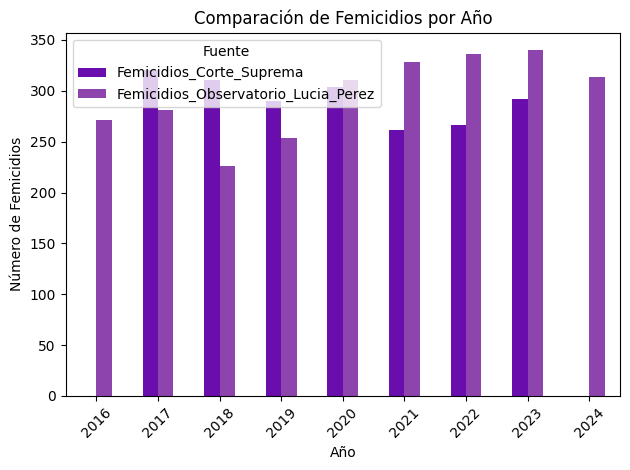

    Año  Femicidios_Corte_Suprema  Femicidios_Observatorio_Lucia_Perez
0  2016                       NaN                                  271
1  2017                     320.0                                  281
2  2018                     311.0                                  226
3  2019                     290.0                                  254
4  2020                     304.0                                  311
5  2021                     261.0                                  328
6  2022                     266.0                                  336
7  2023                     292.0                                  340
8  2024                       NaN                                  314


In [55]:
# Corte Suprema
femicidios_corte = victimas_df.groupby('Año')['Nro_victima'].sum()

# Observatorio Lucía Pérez: solo entre 2012 y 2025
femicidios_observatorio = femicidios_df[femicidios_df['Año'].between(2016, 2025)].groupby('Año').size()

# Comparación
comparison_df = pd.DataFrame({ 
    'Femicidios_Corte_Suprema': femicidios_corte,
    'Femicidios_Observatorio_Lucia_Perez': femicidios_observatorio
}).reset_index()

#paleta de violetas 
violeta_paleta = ['#6a0dad', '#8e44ad', '#9b59b6', '#bb8fce', '#c39bd3', '#d7bde2']

# Graficar
plt.figure(figsize=(12, 6))
comparison_df.plot(x='Año', kind='bar', color=violeta_paleta)
plt.title('Comparación de Femicidios por Año')
plt.xlabel('Año')
plt.ylabel('Número de Femicidios')  
plt.xticks(rotation=45)
plt.legend(title='Fuente')  
plt.tight_layout()
plt.show()
#ver comparacion
print(comparison_df)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.


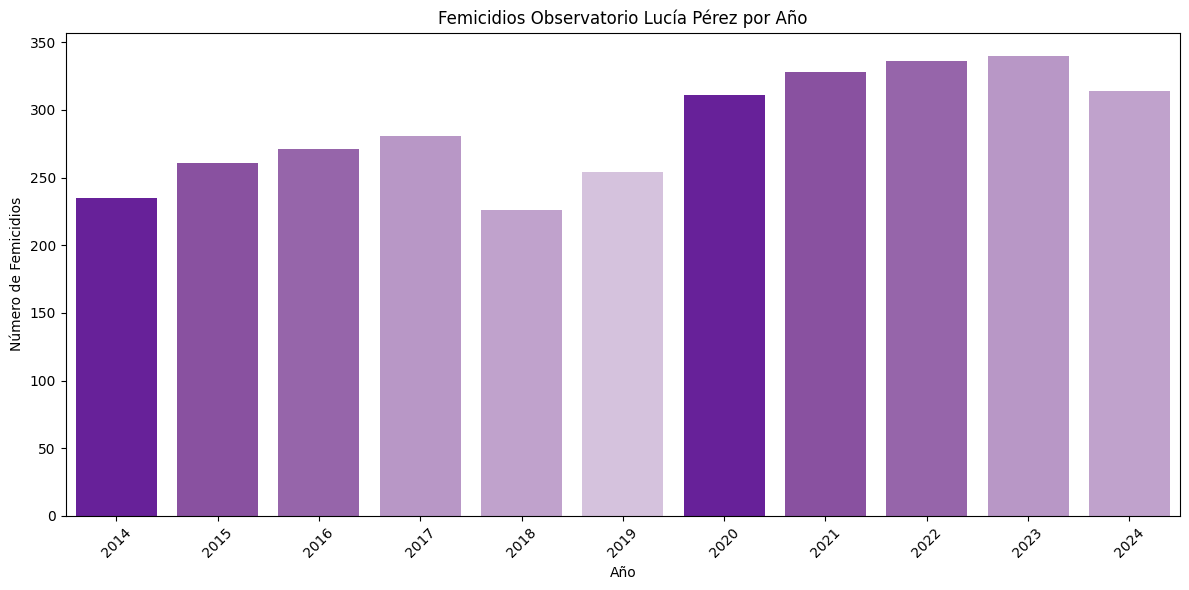

Total de Femicidios por Año (Observatorio Lucía Pérez):
Año
2014    235
2015    261
2016    271
2017    281
2018    226
2019    254
2020    311
2021    328
2022    336
2023    340
2024    314
Name: count, dtype: int64


In [56]:
plt.figure(figsize=(12, 6))
sns.countplot(data=femicidios_df, x='Año', palette=violeta_paleta)
plt.title('Femicidios Observatorio Lucía Pérez por Año')
plt.xlabel('Año')
plt.ylabel('Número de Femicidios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#mostrar resultados
print("Total de Femicidios por Año (Observatorio Lucía Pérez):")
print(femicidios_df['Año'].value_counts().sort_index())


HITOS IMPORTANTES PARA EL ANÁLISIS

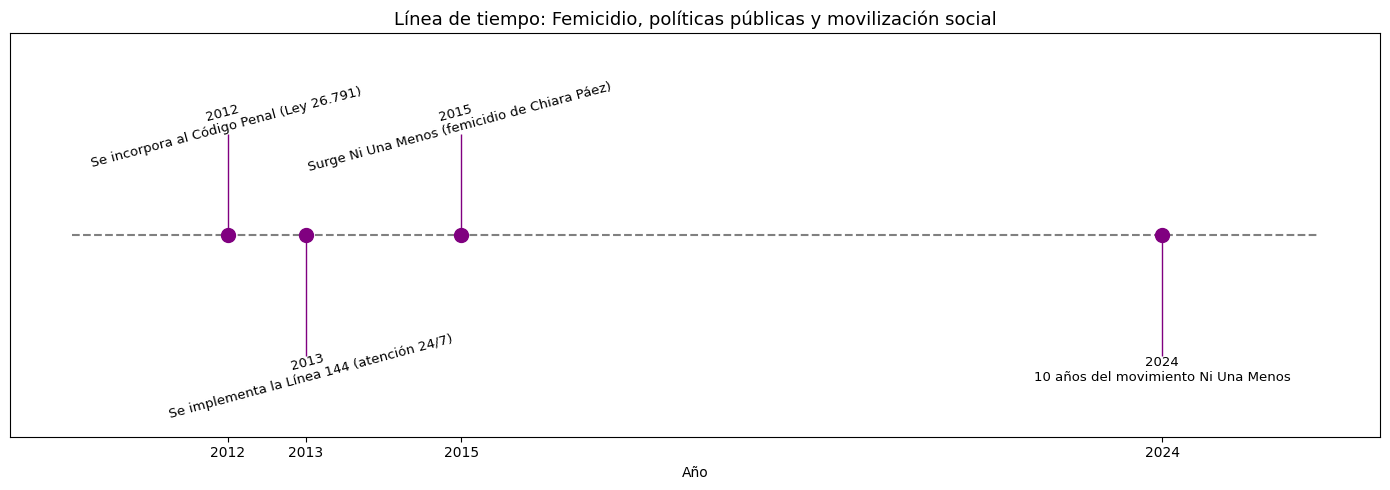

In [57]:
import matplotlib.pyplot as plt

# Fechas y eventos
fechas = [2012, 2013, 2015, 2024]
eventos = [
    "Se incorpora al Código Penal (Ley 26.791)",
    "Se implementa la Línea 144 (atención 24/7)",
    "Surge Ni Una Menos (femicidio de Chiara Páez)",
    "10 años del movimiento Ni Una Menos"
]

# Crear figura
plt.figure(figsize=(14, 5))
plt.hlines(0, min(fechas)-2, max(fechas)+2, colors='gray', linestyles='dashed')
plt.scatter(fechas, [0]*len(fechas), color='purple', s=100, zorder=5)

# Alternar la altura y mejorar separación
for i, (fecha, evento) in enumerate(zip(fechas, eventos)):
    altura = 0.5 if i % 2 == 0 else -0.6
    alineacion = 'bottom' if i % 2 == 0 else 'top'
    rotacion = 0 if len(evento) < 40 else 15  # Rotar si es muy largo
    
    # Línea vertical
    plt.vlines(fecha, 0, altura, color='purple', linewidth=1)
    
    # Texto
    plt.text(fecha, altura, f"{fecha}\n{evento}", ha='center', va=alineacion,
             fontsize=9.5, rotation=rotacion, wrap=True)

# Ajustes estéticos
plt.ylim(-1, 1)
plt.yticks([])
plt.xticks(fechas)
plt.title("Línea de tiempo: Femicidio, políticas públicas y movilización social", fontsize=13)
plt.xlabel("Año")
plt.tight_layout()
plt.show()





Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.


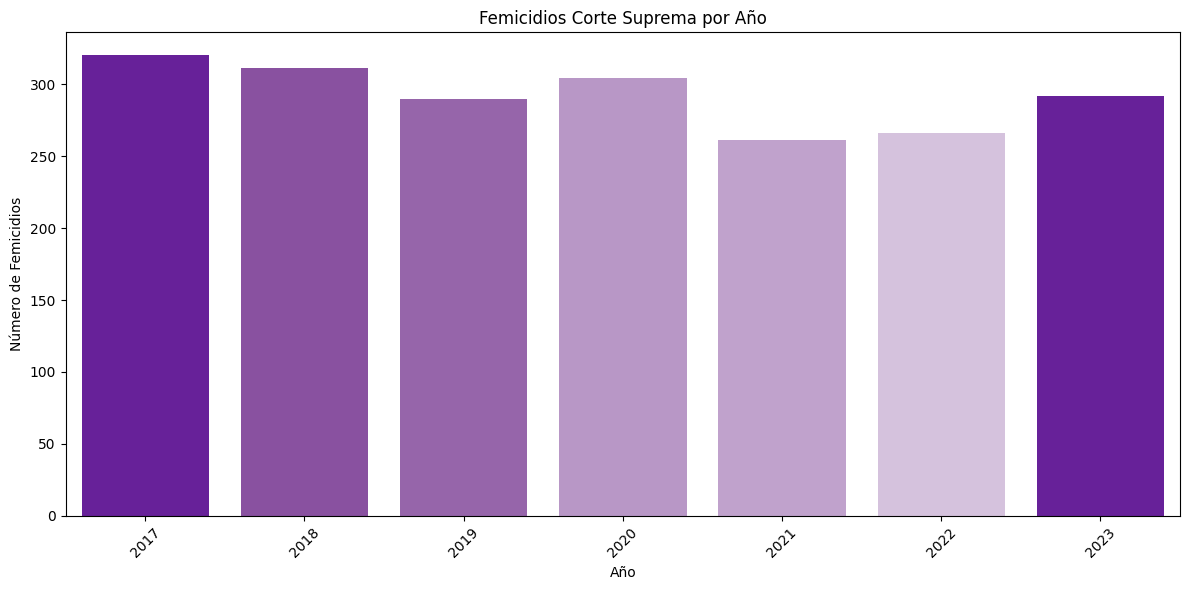

Total de Femicidios por Año (Corte Suprema):
    Año  Nro_victima
0  2017          320
1  2018          311
2  2019          290
3  2020          304
4  2021          261
5  2022          266
6  2023          292


In [58]:
#femicidios corte suprema
femicidios_corte = victimas_df.groupby('Año')['Nro_victima'].sum().reset_index()
femicidios_corte.columns = ['Año', 'Nro_victima']
#graficar femicidios corte suprema en grafico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=femicidios_corte, x='Año', y='Nro_victima', palette=violeta_paleta)
plt.title('Femicidios Corte Suprema por Año')
plt.xlabel('Año')
plt.ylabel('Número de Femicidios')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()
# Mostrar total de femicidios por año
print("Total de Femicidios por Año (Corte Suprema):")
print(femicidios_corte) 


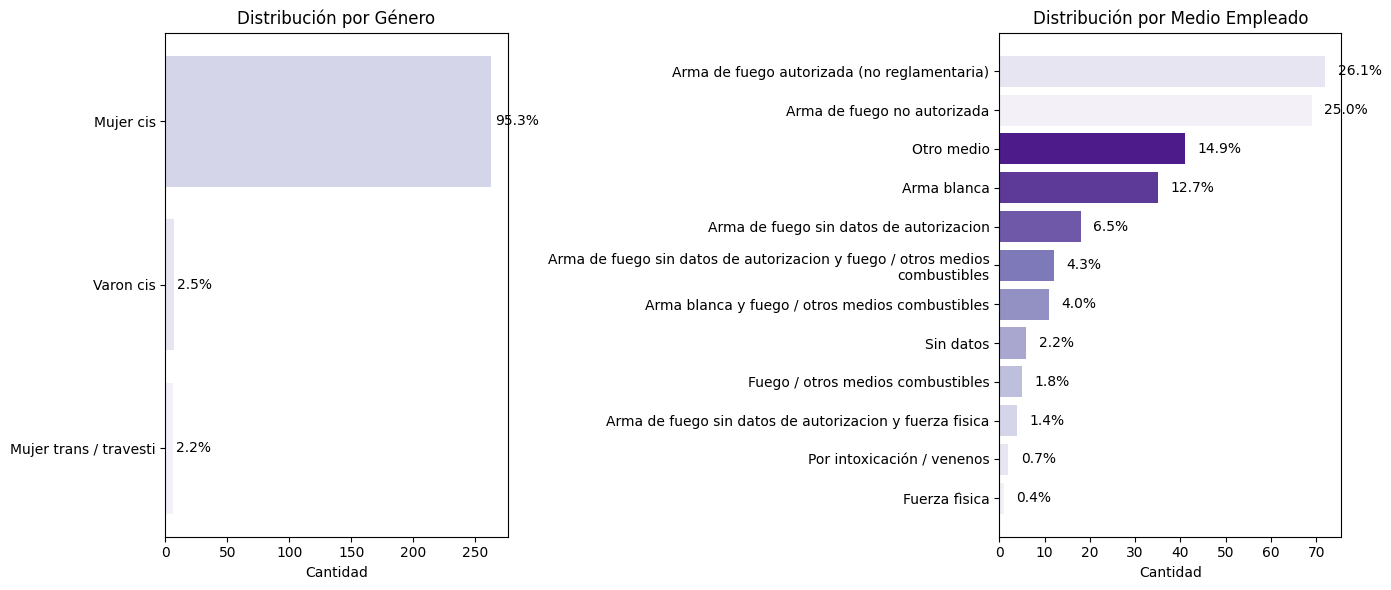

Genero
Mujer cis                 263
Varon cis                   7
Mujer trans / travesti      6
Name: count, dtype: int64

Medio_empleado
Arma de fuego autorizada (no reglamentaria)                                     72
Arma de fuego no autorizada                                                     69
Otro medio                                                                      41
Arma blanca                                                                     35
Arma de fuego sin datos de autorizacion                                         18
Arma de fuego sin datos de autorizacion y fuego / otros medios\ncombustibles    12
Arma blanca y fuego / otros medios combustibles                                 11
Sin datos                                                                        6
Fuego / otros medios combustibles                                                5
Arma de fuego sin datos de autorizacion y fuerza fisica                          4
Por intoxicación / venenos                                                       2
Fuerza fìsica                                                           

In [59]:
def plot_barh_with_percentages(series, ax, title, palette):
    total = series.sum()
    series_sorted = series.sort_values()
    ax.barh(series_sorted.index, series_sorted.values, color=palette[:len(series_sorted)])
    ax.set_title(title)
    ax.set_xlabel('Cantidad')
    for i, value in enumerate(series_sorted.values):
        porcentaje = value / total * 100
        ax.text(value + total*0.01, i, f"{porcentaje:.1f}%", va='center')

# Paleta violeta
violeta_paleta = sns.color_palette("Purples", n_colors=10)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_barh_with_percentages(victimas_df['Genero'].value_counts(), axs[0], 'Distribución por Género', violeta_paleta)
plot_barh_with_percentages(victimas_df['Medio_empleado'].value_counts(), axs[1], 'Distribución por Medio Empleado', violeta_paleta)

plt.tight_layout()
plt.show()
display(victimas_df['Genero'].value_counts())
display(victimas_df['Medio_empleado'].value_counts())


Clasificacion_Condena
Sin datos     2141
Condena        817
No condena     199
Name: count, dtype: int64


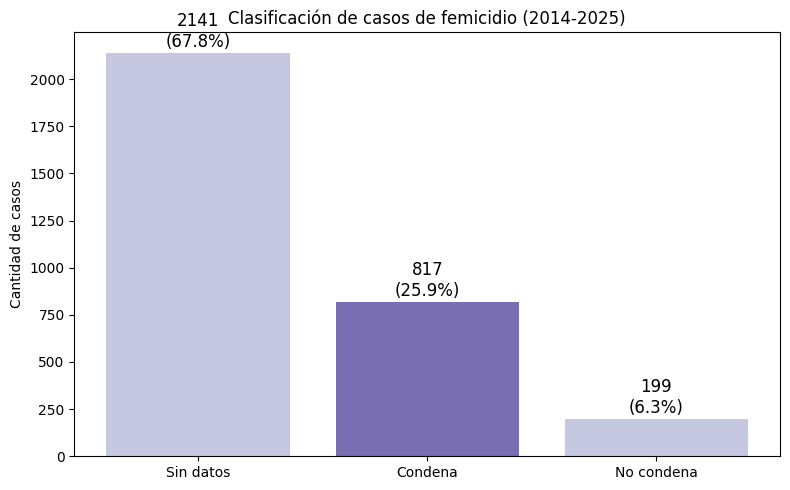

Clasificacion_Condena
Sin datos     2141
Condena        817
No condena     199
Name: count, dtype: int64

In [ ]:
# Casos que NO son condenas
no_condena = [
    'absolución', 'absuelto', 'absueltos', 'absueltos', 'no culpable', 'inimputable',
    'ininputable', 'ABSUELTOS' 'causa archivada', 'medidas tutelares', 'sobreseído', 'años', 'Perpetua y Absolución', 'Medidas tutelares'
]

# Frases irrelevantes o basura de texto
frases_invalidas = [
    '', 'nan', 'none', 'noneType',  '10 años (García) y 5 años (Luna)'
    'su familia nunca dejó de reclamar y acusó a los investigadores del caso de favorecer al sospechoso, basándose solo en el testimonio en cámara gesell del hermanito de la víctima, pero el acusado brian fabián olmos, hijo de un efectivo policial quedó en libertad.'
]

# Convertimos todo a minúsculas para comparar mejor
condena_clean = femicidios_df['Condena'].astype(str).str.lower().str.strip()

# Función de clasificación
def clasificar_condena(valor):
    if valor in frases_invalidas or valor == 'nan':
        return 'Sin datos'
    elif any(nc in valor for nc in no_condena):
        return 'No condena'
    else:
        return 'Condena'

# Aplicamos al DataFrame
femicidios_df['Clasificacion_Condena'] = condena_clean.apply(clasificar_condena)

# Conteo
conteo = femicidios_df['Clasificacion_Condena'].value_counts()
print(conteo)

#graficar solo para el periodo de tiempo que necesitamos años 2014-2025

# Filtrar el DataFrame por años 2014 a 2025
femicidios_filtrado = femicidios_df[(femicidios_df['Año'] >= 2014) & (femicidios_df['Año'] <= 2025)].copy()

# Contar las clasificaciones en el rango filtrado
conteo_filtrado = femicidios_filtrado['Clasificacion_Condena'].value_counts()

# Colores para las barras (se puede ajustar)
# Paleta violeta
violeta_paleta = sns.color_palette("Purples", n_colors=2) # Condena, No condena, Sin datos

# Gráfico de barras
plt.figure(figsize=(8,5))
bars = plt.bar(conteo_filtrado.index, conteo_filtrado.values, color=violeta_paleta)

# Mostrar número y porcentaje encima de cada barra
total = conteo_filtrado.sum()
for bar in bars:
    height = bar.get_height()
    porcentaje = height / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, height + total*0.01, 
             f'{height}\n({porcentaje:.1f}%)', 
             ha='center', fontsize=12)

plt.title('Clasificación de casos de femicidio (2014-2025)')
plt.ylabel('Cantidad de casos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
conteo_filtrado

In [61]:
femicidios_df.head()

,id,Nombre,Edad,Día,Mes,Año,Lugar,Departamento / Partido / Comuna,Provincia,Procesado/ sospechoso,...,Hijxs,¿Estaba embarazada?,¿Estuvo Desaparecida?,¿El sospechoso se suicidó?,Denuncias Previas,Integrante de fuerzas de seguridad,Caso,Fuentes,Fecha,Clasificacion_Condena
122,4947,Agustina Caro,30,31,12,2024,Roque Sáenz Peña,Comandante Fernández,Chaco,No se informa,...,NaN,NaN,NaN,NaN,NaN,Sí,El imputado pertenece a las Fuerzas de Segurid...,https://noticiasargentinas.com/sociedad/chaco-...,2024-12-31,Sin datos
123,4946,Sara Sosa,90,31,12,2024,Ingeniero Maschwitz,Escobar,Buenos Aires,Luis César Benítez y Diego Gastón Acosta,...,NaN,NaN,NaN,NaN,NaN,NaN,Los sospechosos fueron detenidos.,https://tn.com.ar/policiales/2025/01/02/ingeni...,2024-12-31,Sin datos
124,4945,María Florencia Castillo,35,31,12,2024,Merlo,Merlo,Buenos Aires,No determinado,...,NaN,NaN,NaN,NaN,NaN,Sí,Era policía y convivía con otro integrante de ...,https://infocielo.com/judiciales-y-policiales/...,2024-12-31,Sin datos
125,4944,Luciana Torres,35,30,12,2024,Capital Santiago del Estero,Capital Santiago del Estero,Santiago del Estero,Joaquín Cesca,...,NaN,NaN,NaN,NaN,NaN,NaN,La Familia reclama se investigue como Femicidio,https://www.quepasasalta.com.ar/policiales/luc...,2024-12-30,Sin datos
126,4943,No se informa,No se informa,29,12,2024,Quilmes,Quilmes,Buenos Aires,I.G.P.,...,NaN,NaN,NaN,NaN,NaN,NaN,"La víctima es una mujer trans, aún no se la pu...",https://www.infobae.com/sociedad/policiales/20...,2024-12-29,Sin datos


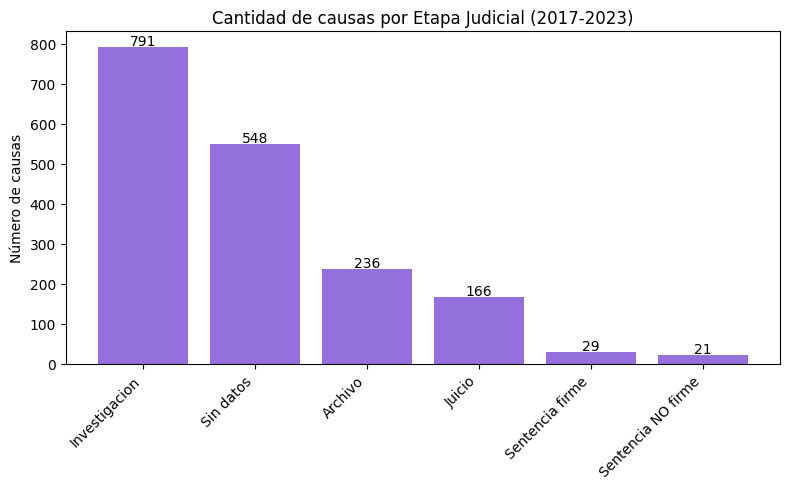

Etapa_causa
Investigacion         791
Sin datos             548
Archivo               236
Juicio                166
Sentencia firme        29
Sentencia NO firme     21
Name: count, dtype: int64

In [62]:
causas_df['Etapa_causa'] = causas_df['Etapa_causa'].fillna('Sin datos').astype(str)

conteo_etapas = causas_df['Etapa_causa'].value_counts()

plt.figure(figsize=(8,5))
bars = plt.bar(conteo_etapas.index, conteo_etapas.values, color='mediumpurple')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{height}', ha='center')

plt.title('Cantidad de causas por Etapa Judicial (2017-2023)')
plt.ylabel('Número de causas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
conteo_etapas

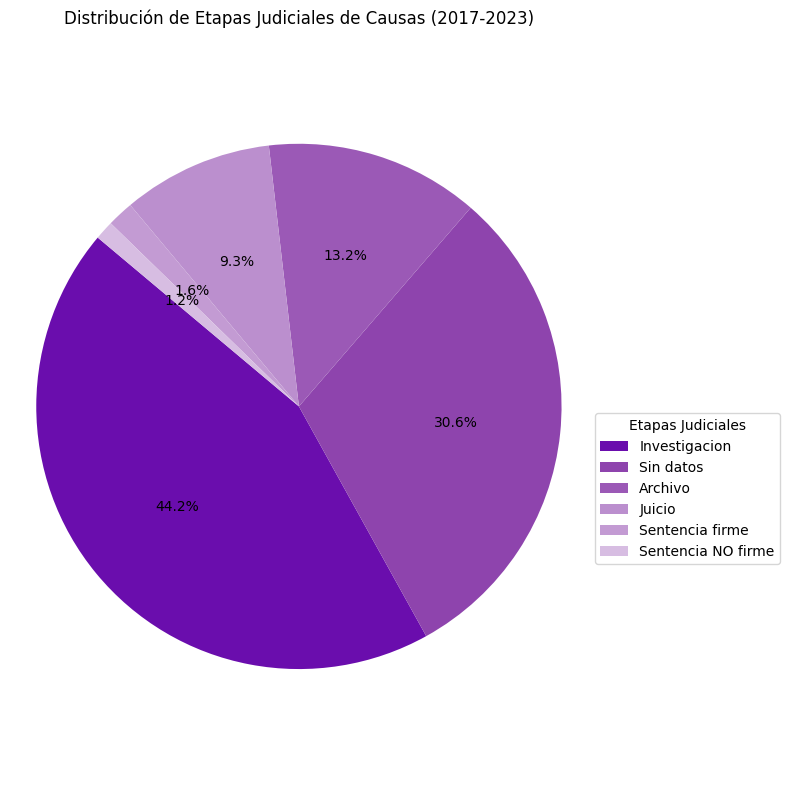

In [63]:
plt.figure(figsize=(8, 8))
plt.pie(
    conteo_etapas,
    labels=None,  # NO mostrar etiquetas sobre el gráfico
    autopct='%1.1f%%',  # Mostrar solo los porcentajes sobre las porciones
    startangle=140,
    colors=['#6a0dad', '#8e44ad', '#9b59b6', '#bb8fce', '#c39bd3', '#d7bde2'],  # Paleta de violetas
)
plt.title('Distribución de Etapas Judiciales de Causas (2017-2023)')
plt.axis('equal')  # Para que el gráfico sea un círculo
plt.legend(
    labels=conteo_etapas.index,  # Etiquetas solo en la leyenda
    title='Etapas Judiciales',
    loc='upper left',
    bbox_to_anchor=(1, 0.5)
)
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



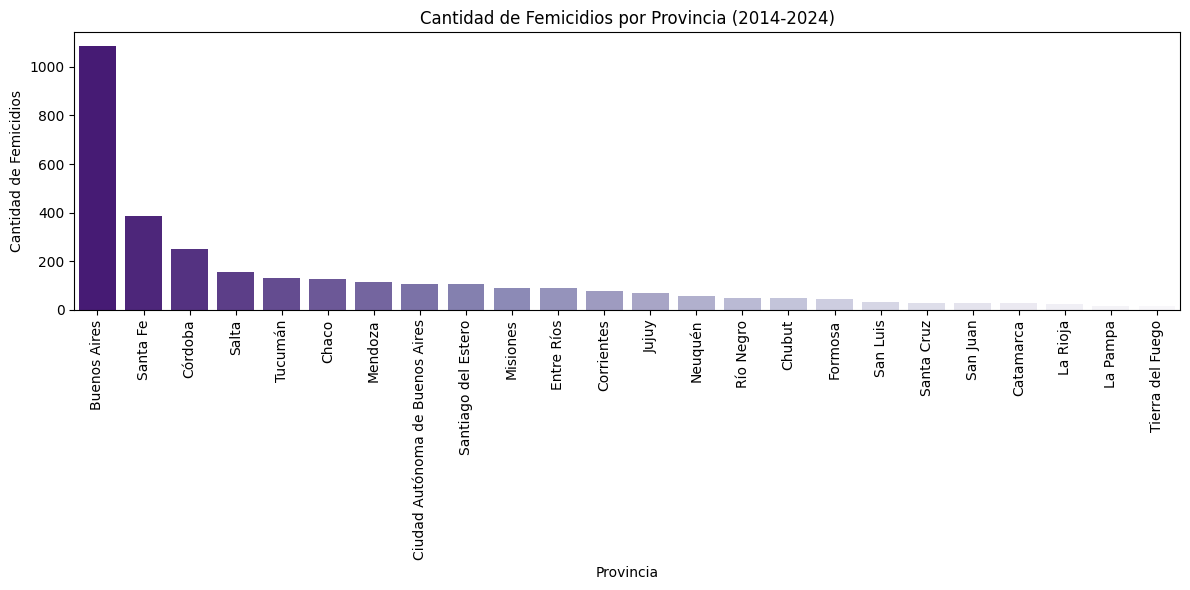

,Provincia,Cantidad_Femicidios
0,Buenos Aires,1088
20,Santa Fe,388
6,Córdoba,251
16,Salta,156
23,Tucumán,132
2,Chaco,126
12,Mendoza,115
4,Ciudad Autónoma de Buenos Aires,106
21,Santiago del Estero,105
13,Misiones,91


In [64]:

# Agrupar cantidad de femicidios por provincia
femicidios_prov = femicidios_df.groupby('Provincia').size().reset_index(name='Cantidad_Femicidios')

# Ordenar de mayor a menor para que se vea mejor
femicidios_prov = femicidios_prov.sort_values(by='Cantidad_Femicidios', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=femicidios_prov, x='Provincia', y='Cantidad_Femicidios', palette='Purples_r')
plt.xticks(rotation=90)
plt.title('Cantidad de Femicidios por Provincia (2014-2024)')
plt.ylabel('Cantidad de Femicidios')
plt.xlabel('Provincia')
plt.tight_layout()
plt.show()
femicidios_prov


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



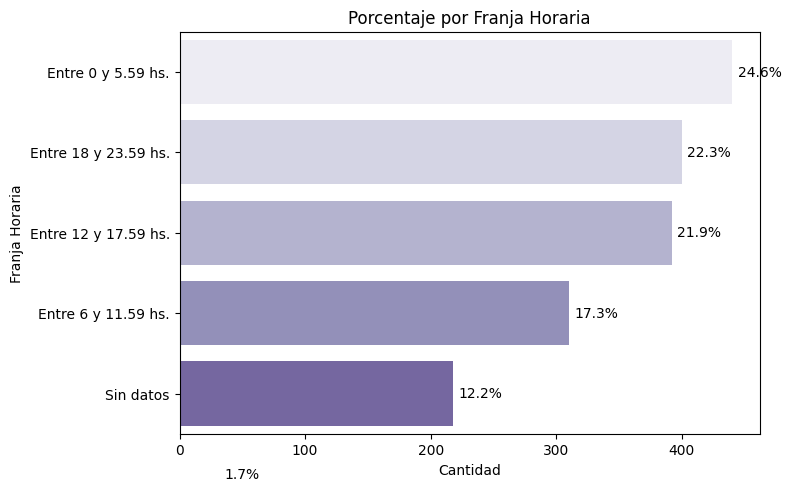

Franja_horaria
Entre 0 y 5.59 hs.      440
Entre 18 y 23.59 hs.    400
Entre 12 y 17.59 hs.    392
Entre 6 y 11.59 hs.     310
Sin datos               218
NaN                      31
Name: count, dtype: int64

In [65]:
# Contar ocurrencias por franja horaria
franja_counts = causas_df['Franja_horaria'].value_counts(dropna=False)
total = franja_counts.sum()

# Definir paleta de colores (por ejemplo, tonos de violeta)
palette = sns.color_palette("Purples", len(franja_counts))

# Crear gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=franja_counts.values, y=franja_counts.index, palette=palette)

# Añadir porcentajes a las barras
for i, v in enumerate(franja_counts.values):
    pct = v / total * 100
    ax.text(v + max(franja_counts.values)*0.01, i, f"{pct:.1f}%", color='black', va='center')

# Etiquetas y diseño
plt.title('Porcentaje por Franja Horaria')
plt.xlabel('Cantidad')
plt.ylabel('Franja Horaria')
plt.tight_layout()
plt.show()
display(franja_counts)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



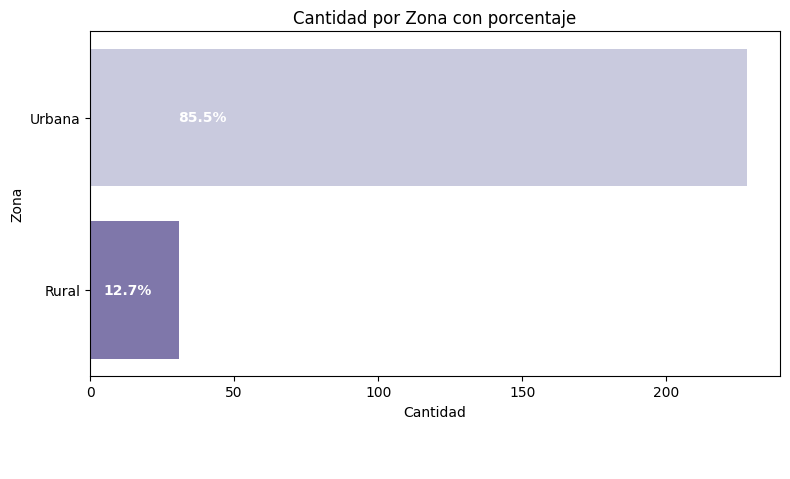

,Zona,Cantidad,Porcentaje
0,NaN,1532,85.538805
1,Urbana,228,12.730318
2,Rural,31,1.730877


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Contamos los datos así:
zona_counts = causas_df['Zona'].value_counts(dropna=False)
total = zona_counts.sum()

# Creamos DataFrame con cantidad y porcentaje
zona_df = pd.DataFrame({
    'Zona': zona_counts.index,
    'Cantidad': zona_counts.values
})
zona_df['Porcentaje'] = 100 * zona_df['Cantidad'] / total

# Gráfico de barras horizontales con porcentaje anotado
plt.figure(figsize=(8, 5))
sns.barplot(data=zona_df, x='Cantidad', y='Zona', palette='Purples')

plt.title('Cantidad por Zona con porcentaje')
plt.xlabel('Cantidad')
plt.ylabel('Zona')

# Anotar porcentaje dentro de cada barra (alineado a la izquierda, con un pequeño margen)
for i, (cantidad, porcentaje) in enumerate(zip(zona_df['Cantidad'], zona_df['Porcentaje'])):
    plt.text(cantidad * 0.02, i, f'{porcentaje:.1f}%', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()
display(zona_df)

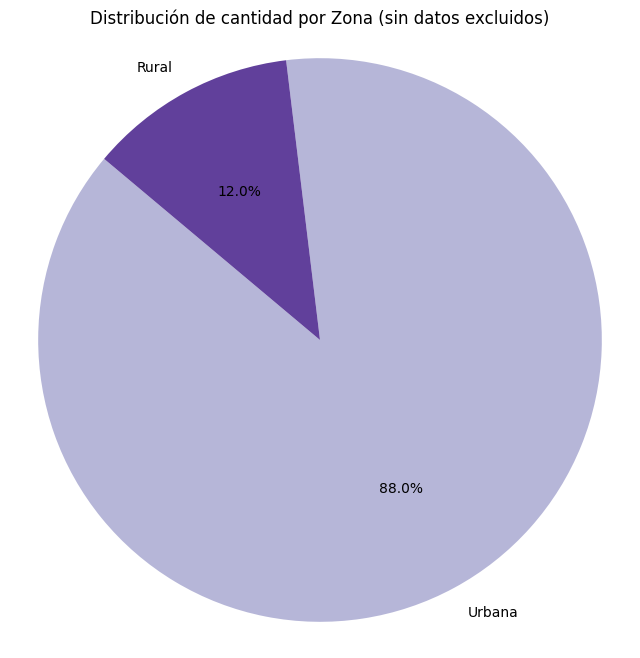

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Filtrar y contar excluyendo NaN y 'Sin datos'
zona_filtrada = causas_df[~causas_df['Zona'].isin(['Sin datos']) & causas_df['Zona'].notna()]
zona_counts = zona_filtrada['Zona'].value_counts()
total = zona_counts.sum()

# Crear DataFrame para gráfico
zona_df = pd.DataFrame({
    'Zona': zona_counts.index,
    'Cantidad': zona_counts.values
})
zona_df['Porcentaje'] = 100 * zona_df['Cantidad'] / total

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    zona_df['Cantidad'],
    labels=zona_df['Zona'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Purples(np.linspace(0.4, 0.8, len(zona_df))),
    textprops={'color': 'black', 'fontsize': 10}
)
plt.title('Distribución de cantidad por Zona (sin datos excluidos)')
plt.axis('equal')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



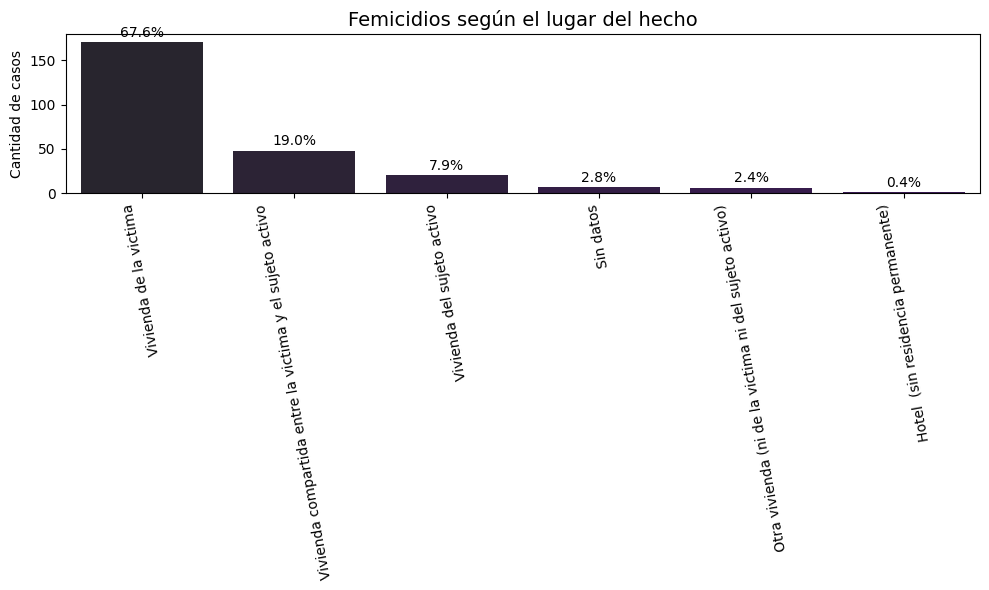


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



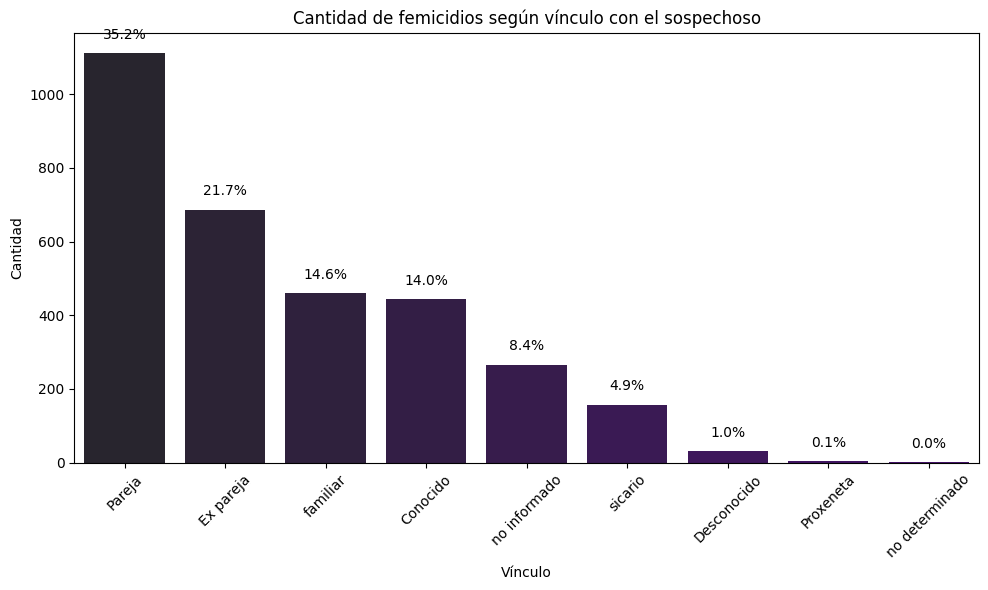

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar paleta
paleta_morada_oscura = sns.dark_palette("#4B0082", n_colors=10)  # Ajustar cantidad si hace falta

# --- Gráfico 1: Lugar del hecho ---
conteo_lugares = causas_df["Lugar"].value_counts().reset_index()
conteo_lugares.columns = ["Lugar del hecho", "Cantidad"]
total_lugares = conteo_lugares["Cantidad"].sum()
conteo_lugares["Porcentaje"] = (conteo_lugares["Cantidad"] / total_lugares) * 100

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=conteo_lugares, x="Lugar del hecho", y="Cantidad", palette=paleta_morada_oscura[:len(conteo_lugares)])
plt.title("Femicidios según el lugar del hecho", fontsize=14)
plt.xlabel("")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=100)

# Agregar porcentaje encima de cada barra
for i, row in conteo_lugares.iterrows():
    plt.text(i, row["Cantidad"] + total_lugares*0.01, f'{row["Porcentaje"]:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# --- Gráfico 2: Vínculo con sospechoso ---
conteo_vinculo = femicidios_df['Vínculo'].value_counts().reset_index()
conteo_vinculo.columns = ['Vínculo', 'Cantidad']
total_vinculo = conteo_vinculo["Cantidad"].sum()
conteo_vinculo["Porcentaje"] = (conteo_vinculo["Cantidad"] / total_vinculo) * 100

plt.figure(figsize=(10, 6))
ax2 = sns.barplot(data=conteo_vinculo, x='Vínculo', y='Cantidad', palette=paleta_morada_oscura[:len(conteo_vinculo)])
plt.title('Cantidad de femicidios según vínculo con el sospechoso')
plt.xlabel('Vínculo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Agregar porcentaje encima de cada barra
for i, row in conteo_vinculo.iterrows():
    plt.text(i, row["Cantidad"] + total_vinculo*0.01, f'{row["Porcentaje"]:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [120]:
conteo_vinculo


,Vínculo,Cantidad,Porcentaje
0,Pareja,1111,35.191638
1,Ex pareja,686,21.729490
2,familiar,460,14.570795
3,Conocido,443,14.032309
4,no informado,266,8.425721
5,sicario,156,4.941400
6,Desconocido,31,0.981945
7,Proxeneta,3,0.095027
8,no determinado,1,0.031676


In [70]:
femicidios_df = femicidios_df.rename(columns={'¿El sospechoso se suicidó?': 'Suicidio_Sospechoso'})
# Convertir a string y estandarizar mayúsculas/minúsculas
femicidios_df['Suicidio_Sospechoso'] = femicidios_df['Suicidio_Sospechoso'].astype(str).str.strip().str.lower()

# Reemplazar valores equivalentes a sí por "Sí"
femicidios_df.loc[femicidios_df['Suicidio_Sospechoso'].isin(['sí', 's�', 'si']), 'Suicidio_Sospechoso'] = 'Sí'

# Para todo lo que no sea "sí" asignar "Sin datos"
femicidios_df.loc[~(femicidios_df['Suicidio_Sospechoso'] == 'Sí'), 'Suicidio_Sospechoso'] = 'No/Sin datos'

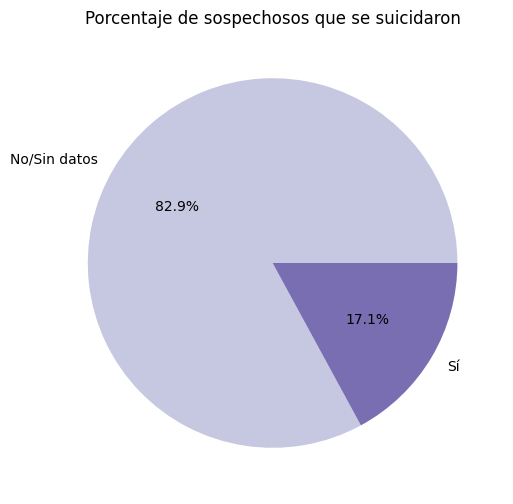

Suicidio_Sospechoso
No/Sin datos    2618
Sí               539
Name: count, dtype: int64

In [71]:
import matplotlib.pyplot as plt

# Calcular cantidad y etiquetas
counts = femicidios_df['Suicidio_Sospechoso'].value_counts()
labels = counts.index

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('Purples', len(counts)))
plt.title('Porcentaje de sospechosos que se suicidaron')
plt.show()

display(counts)

In [72]:
import pandas as pd
import unidecode
import re

def limpiar_texto(texto):
    if pd.isna(texto):
        return ''
    texto = texto.lower().strip()
    texto = unidecode.unidecode(texto)  # quitar tildes
    texto = re.sub(r'\s+', ' ', texto)  # quitar espacios extras
    return texto

# Lista con todas las variantes y errores
formas_raw = [
    'Baleada', 'Apuñalada', 'A golpes', 'Ahorcada', 'Quemada', 'Degollada',
    'Ahorcada y violada', 'A golpes y violada', 'No determinado',
    'Descuartizada', 'No se informa', 'Incendiada la casa', 'Desaparecida',
    'Arrojada al vacío', 'A mazazos', 'Apuñalada y violada', 'Ahogada',
    'A machetazos', 'Atropellada', 'Suicidio', 'A hachazos', 'Envenenada',
    'Drogada', 'A martillazos', 'Violada', 'Empalada', 'En investigación',
    'Asfixiada', 'Ahoracada', 'Degollada y violada', 'Enterrada',
    'Empalada y violada', 'Baleada y violada', 'Arrojada de un auto',
    'A determinar', 'Prendida fuego la casa', 'Descuartizada y violada',
    'Quemada y decapitada', 'No edeterminado', 'Desparecida',
    'Con un hacha', 'A golpes y quemada', 'No dterminado',
    'Inhalación de monóxido de carbono', 'Choque intencional', 'Desangrada',
    'A Hachazos', 'A Golpes', 'Ahorcada y apuñalada', 'Apuñanalda',
    'Arrojada desde una moto', 'Masazos', 'A piedrazos',
    'Abusada sexualmente', 'Violada y apuñalada', 'Apuñalada y baleada',
    'Suicidio inducido', 'Golpes', 'Intoxicada', 'Paro cardiaco',
    'Estrangulada', 'Drogada y violada', 'Violada y asfixiada',
    'Parto forzado', 'Deshidratada', 'Arrollada por un tren',
    'Ahorcada y baleada', 'Sobredosis', 'Baleado', 'Descuatizada',
    'Torturada y violada', 'Ahogada y violada en grupo',
    'Violada en manada', 'Quemada y violada', 'Enterrada viva', 'À golpes',
    'Afixiada'
]

# Construyo el mapa, haciendo limpieza de mayúsculas y tildes
mapa_formas = {
    'baleada': 'baleada',
    'baleado': 'baleada',
    'apuñalada': 'apuñalada',
    'apuñanalda': 'apuñalada',
    'apuñalada y violada': 'apuñalada',
    'apuñalada y baleada': 'apuñalada',
    'apuñalada y violada y golpes': 'apuñalada',
    'a golpes': 'golpes',
    'a golpes y violada': 'golpes',
    'a golpes y quemada': 'golpes',
    'golpes': 'golpes',
    'masazos': 'golpes',
    'a mazazos': 'golpes',
    'a machetazos': 'hachazos',
    'a hachazos': 'hachazos',
    'con un hacha': 'hachazos',
    'a martillazos': 'martillazos',
    'martillazos': 'martillazos',
    'ahorcada': 'ahorcada',
    'ahoracada': 'ahorcada',
    'ahorcada y violada': 'ahorcada',
    'ahorcada y apuñalada': 'ahorcada',
    'ahorcada y baleada': 'ahorcada',
    'ahogada': 'ahogada',
    'ahogada y violada': 'ahogada',
    'envenenada': 'envenenada',
    'drogada': 'drogada',
    'drogada y violada': 'drogada',
    'violada': 'violada',
    'violada y apuñalada': 'violada',
    'violada y asfixiada': 'violada',
    'violada en manada': 'violada',
    'abusada sexualmente': 'violada',
    'descuartizada': 'descuartizada',
    'descuatizada': 'descuartizada',
    'quemada': 'quemada',
    'quemada y violada': 'quemada',
    'quemada y decapitada': 'quemada',
    'no determinado': 'no determinado',
    'no edeterminado': 'no determinado',
    'no dterminado': 'no determinado',
    'no se informa': 'no informado',
    'no informado': 'no determinado',
    'desaparecida': 'desaparecida',
    'desparecida': 'desaparecida',
    'arrojada al vacio': 'arrojada',
    'arrojada desde una moto': 'arrojada',
    'arrojada de un auto': 'arrojada',
    'arrojada': 'arrojada',
    'suicidio': 'suicidio',
    'suicidio inducido': 'suicidio',
    'intoxicada': 'intoxicada',
    'sobredosis': 'sobredosis',
    'asfixiada': 'asfixiada',
    'afixiada': 'asfixiada',
    'estrangulada': 'estrangulada',
    'enterada': 'enterrada',
    'enterrada': 'enterrada',
    'enterrada viva': 'enterrada',
    'paro cardiaco': 'paro cardiaco',
    'parto forzado': 'parto forzado',
    'deshidratada': 'deshidratada',
    'arrollada por un tren': 'arrollada',
    'arrollada': 'arrollada',
    'choque intencional': 'choque intencional',
    'desangrada': 'desangrada',
    'incendiada la casa': 'incendiada la casa',
    'prendida fuego la casa': 'incendiada la casa',
    'torturada y violada': 'torturada y violada',
    'a piedrazos': 'piedrazos',
    'ahogada y violada en grupo': 'ahogada',
    'a golpes y violada': 'golpes',
    'a golpes y quemada': 'golpes',
    'no determinado': 'no determinado',
    #
}

def mapear_forma(texto):
    texto_limpio = limpiar_texto(texto)
    for clave in mapa_formas:
        if clave in texto_limpio:
            return mapa_formas[clave]
    return 'otros'

# Aplicar al dataframe
femicidios_df['forma_limpia'] = femicidios_df['Cómo'].apply(mapear_forma)

# Ver resultados únicos para chequear
print(femicidios_df[['Cómo', 'forma_limpia']].drop_duplicates().sort_values('forma_limpia'))


                            Cómo forma_limpia
2381  Ahogada y violada en grupo      ahogada
158                      Ahogada      ahogada
647         Ahorcada y apuñalada     ahorcada
125                     Ahorcada     ahorcada
426           Ahorcada y violada     ahorcada
...                          ...          ...
313          Apuñalada y violada      violada
2446     Descuartizada y violada      violada
371                      Violada      violada
162          Abusada sexualmente      violada
3163          Empalada y violada      violada

[66 rows x 2 columns]



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



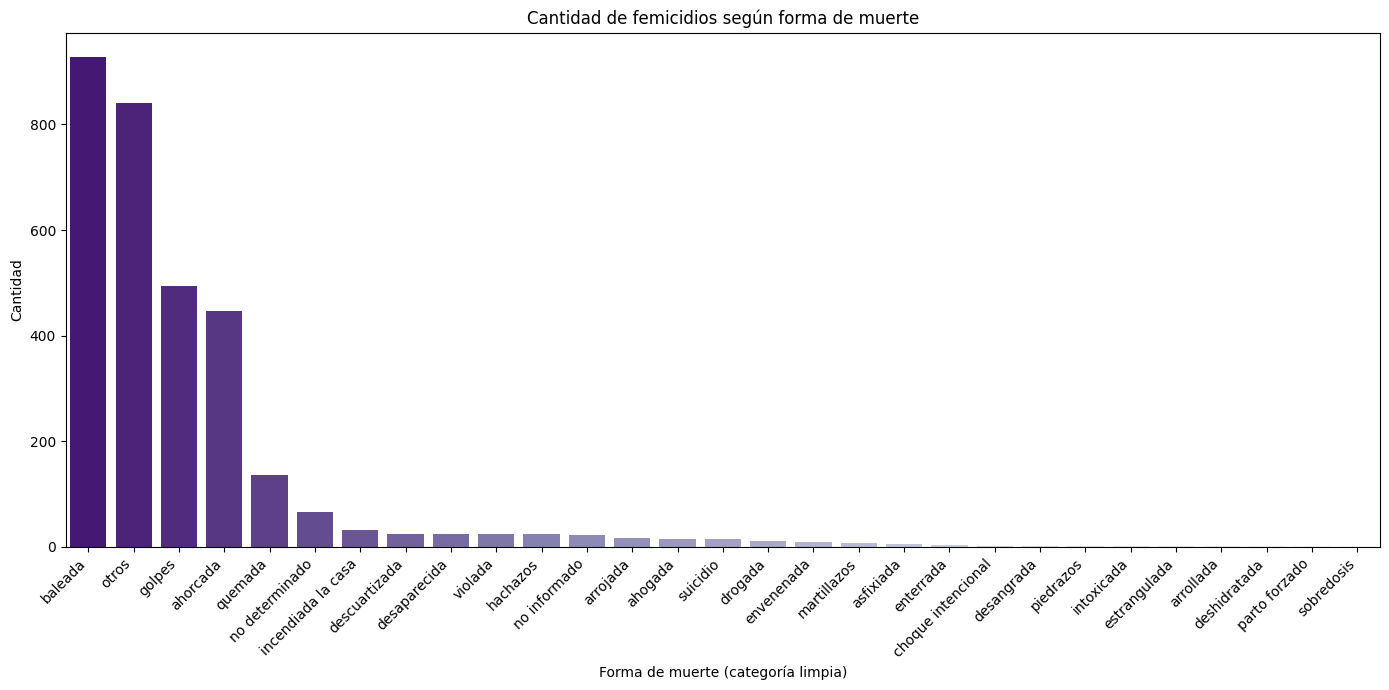

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,7))
orden = femicidios_df['forma_limpia'].value_counts().index  # ordenar por frecuencia
sns.countplot(data=femicidios_df, x='forma_limpia', order=orden, palette='Purples_r')
plt.xticks(rotation=45, ha='right')
plt.title('Cantidad de femicidios según forma de muerte')
plt.xlabel('Forma de muerte (categoría limpia)')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

Migrantes internacionales: 101
Migrantes interprovinciales: 41
Migrantes intraprovinciales: 14
Total víctimas migrantes (al menos una condición): 156


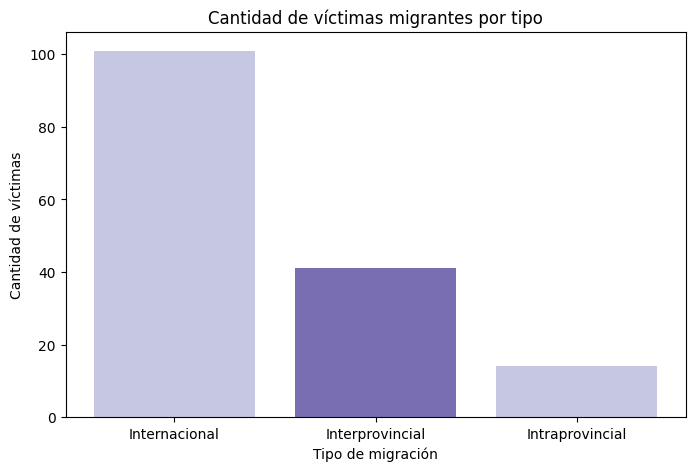

In [74]:
migrantes_internacionales = victimas_df[victimas_df['Victima_migrante_internacional'] == 1].shape[0]
migrantes_interprovinciales = victimas_df[victimas_df['Victima_migrante_interprovincial'] == 1].shape[0]
migrantes_intraprovinciales = victimas_df[victimas_df['Victima_migrante_intraprovincial'] == 1].shape[0]
total_migrantes = victimas_df[
    (victimas_df['Victima_migrante_internacional'] == 1) |
    (victimas_df['Victima_migrante_interprovincial'] == 1) |
    (victimas_df['Victima_migrante_intraprovincial'] == 1)
].shape[0]
print("Migrantes internacionales:", migrantes_internacionales)
print("Migrantes interprovinciales:", migrantes_interprovinciales)
print("Migrantes intraprovinciales:", migrantes_intraprovinciales)
print("Total víctimas migrantes (al menos una condición):", total_migrantes)

#graficar total victimas migrantes

# Contar las víctimas migrantes
migrantes_internacionales = victimas_df[victimas_df['Victima_migrante_internacional'] == 1].shape[0]
migrantes_interprovinciales = victimas_df[victimas_df['Victima_migrante_interprovincial'] == 1].shape[0]
migrantes_intraprovinciales = victimas_df[victimas_df['Victima_migrante_intraprovincial'] == 1].shape[0]

# Datos para graficar
tipos = ['Internacional', 'Interprovincial', 'Intraprovincial']
cantidades = [migrantes_internacionales, migrantes_interprovinciales, migrantes_intraprovinciales]

# Crear gráfico de barras
plt.figure(figsize=(8,5))
plt.bar(tipos, cantidades, color=violeta_paleta[:3])
plt.title('Cantidad de víctimas migrantes por tipo')
plt.xlabel('Tipo de migración')
plt.ylabel('Cantidad de víctimas')
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



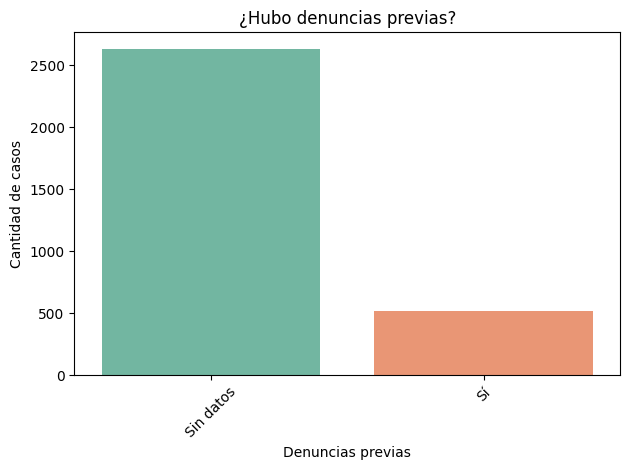

In [75]:
# Normalizamos
femicidios_df['Denuncias Previas'] = femicidios_df['Denuncias Previas'].fillna('Sin datos')
denuncias_counts = femicidios_df['Denuncias Previas'].value_counts()

# Gráfico
sns.barplot(x=denuncias_counts.index, y=denuncias_counts.values, palette="Set2")
plt.title("¿Hubo denuncias previas?")
plt.ylabel("Cantidad de casos")
plt.xlabel("Denuncias previas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

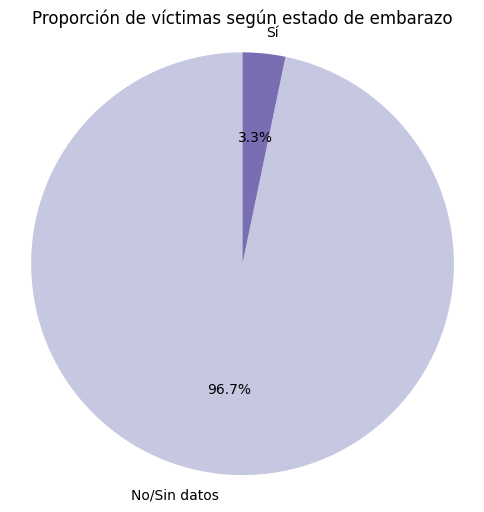

¿Estaba embarazada?
No/Sin datos    3054
Sí               103
Name: count, dtype: int64

In [76]:
# Normalizar los valores de la columna
femicidios_df['¿Estaba embarazada?'] = femicidios_df['¿Estaba embarazada?'].replace(
    {'SÍ': 'Sí', 'sí': 'Sí', 'NO': 'No', 'no': 'No'}
).fillna('No/Sin datos')

# Volver a contar
conteo = femicidios_df['¿Estaba embarazada?'].value_counts()

# Graficar torta
plt.figure(figsize=(6,6))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=violeta_paleta[:len(conteo)])
plt.title('Proporción de víctimas según estado de embarazo')
plt.axis('equal')
plt.show()

# Mostrar los datos
display(conteo)


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar tipo datetime
femicidios_df['Fecha'] = pd.to_datetime(femicidios_df['Fecha'], errors='coerce')

# Crear columna año
femicidios_df['Año'] = femicidios_df['Fecha'].dt.year

# Limpiar columna de desaparición
femicidios_df['¿Estuvo Desaparecida?'] = femicidios_df['¿Estuvo Desaparecida?'].replace(
    {'SÍ': 'Sí', 'sí': 'Sí', 'NO': 'No', 'no': 'No'}
).fillna('Sin datos')

# Agrupar
conteo_total = femicidios_df.groupby('Año').size().rename('Total Femicidios')
conteo_desaparecidas = femicidios_df[femicidios_df['¿Estuvo Desaparecida?'] == 'Sí'].groupby('Año').size().rename('Estuvo Desaparecida')

# Combinar en un DataFrame
df_desaparecidas = pd.concat([conteo_total, conteo_desaparecidas], axis=1).fillna(0)
df_desaparecidas


,Total Femicidios,Estuvo Desaparecida
Año,,
2014,235,14
2015,261,12
2016,271,25
2017,281,17
2018,226,21
2019,254,25
2020,311,36
2021,328,24
2022,336,28


In [78]:
#calcular tasa de femicidios por cada 100.000 mujeres
# Asegurar que la columna 'Mujeres' sea numérica
df_poblacion_fem['Mujeres'] = pd.to_numeric(df_poblacion_fem['Mujeres'], errors='coerce')
# Agrupar por año y provincia
poblacion_anual = df_poblacion_fem.groupby(['Año', 'Provincia'])['Mujeres'].sum().reset_index()
# Unir con el DataFrame de femicidios
femicidios_anual = femicidios_df.groupby(['Año', 'Provincia'])['id'].count().reset_index(name='Femicidios') 
# Unir ambos DataFrames
df_tasa = pd.merge(femicidios_anual, poblacion_anual, on=['Año', 'Provincia'], how='left')
# Calcular tasa por cada 100.000 mujeres
df_tasa['Tasa_Femicidios'] = (df_tasa['Femicidios'] / df_tasa['Mujeres']) * 100000  
# Filtrar por años 2014 a 2025
df_tasa = df_tasa[df_tasa['Año'].between(2014, 2024)]
# Graficar la tasa de femicidios por provincia
df_tasa


,Año,Provincia,Femicidios,Mujeres,Tasa_Femicidios
0,2014,Buenos Aires,86,8411300.0,1.022434
1,2014,Catamarca,1,196541.0,0.508800
2,2014,Chaco,11,571938.0,1.923285
3,2014,Chubut,3,278000.0,1.079137
4,2014,Ciudad Autónoma de Buenos Aires,15,1626722.0,0.922100
...,...,...,...,...,...
250,2024,Santa Cruz,2,195588.0,1.022558
251,2024,Santa Fe,26,1864990.0,1.394109
252,2024,Santiago del Estero,12,511327.0,2.346835
253,2024,Tierra del Fuego,1,93533.0,1.069141


In [79]:
tasa_nacional = df_tasa.groupby('Año').agg({'Femicidios':'sum', 'Mujeres':'sum'}).reset_index()
tasa_nacional['Tasa_Nacional'] = (tasa_nacional['Femicidios'] / tasa_nacional['Mujeres']) * 100000


In [80]:
# Calcular proporción
df_desaparecidas['Proporción desaparecidas (%)'] = (
    df_desaparecidas['Estuvo Desaparecida'] / df_desaparecidas['Total Femicidios'] * 100
).round(2)

display(df_desaparecidas)


,Total Femicidios,Estuvo Desaparecida,Proporción desaparecidas (%)
Año,,,
2014,235,14,5.96
2015,261,12,4.60
2016,271,25,9.23
2017,281,17,6.05
2018,226,21,9.29
2019,254,25,9.84
2020,311,36,11.58
2021,328,24,7.32
2022,336,28,8.33


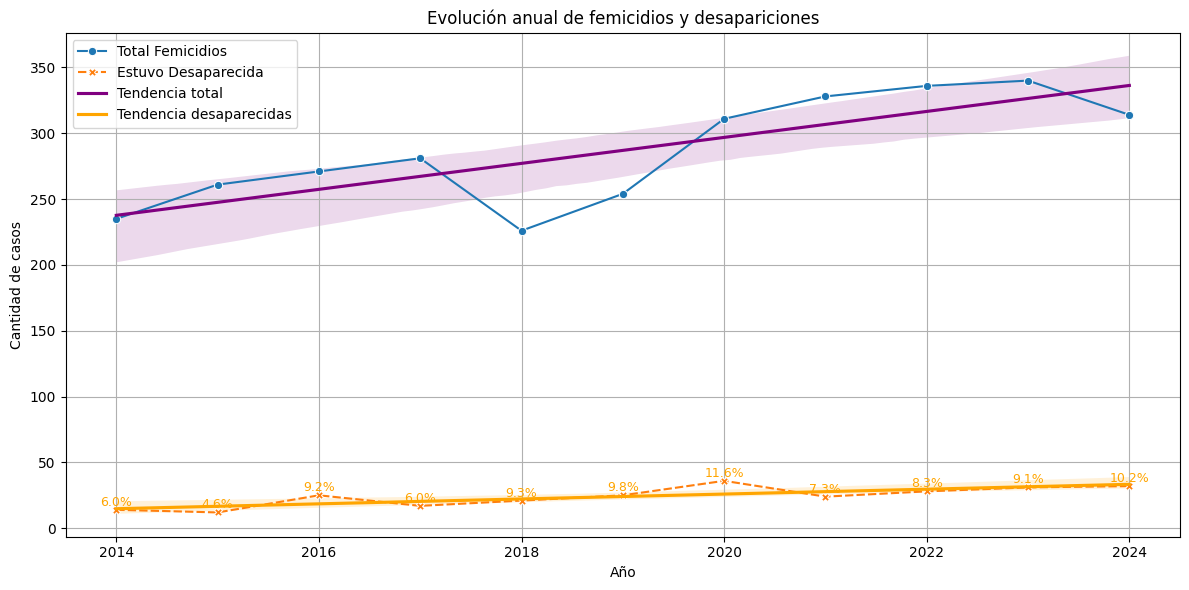

,Total Femicidios,Estuvo Desaparecida,Proporción desaparecidas (%)
Año,,,
2014,235,14,5.96
2015,261,12,4.60
2016,271,25,9.23
2017,281,17,6.05
2018,226,21,9.29
2019,254,25,9.84
2020,311,36,11.58
2021,328,24,7.32
2022,336,28,8.33


In [81]:
import numpy as np

plt.figure(figsize=(12, 6))

# Graficar líneas originales
sns.lineplot(data=df_desaparecidas[['Total Femicidios', 'Estuvo Desaparecida']], markers=True)

# Graficar líneas de tendencia (regresión)
sns.regplot(x=df_desaparecidas.index, y=df_desaparecidas['Total Femicidios'], scatter=False, label="Tendencia total", color='purple')
sns.regplot(x=df_desaparecidas.index, y=df_desaparecidas['Estuvo Desaparecida'], scatter=False, label="Tendencia desaparecidas", color='orange')

# Calcular porcentajes para etiquetas
porcentajes = (df_desaparecidas['Estuvo Desaparecida'] / df_desaparecidas['Total Femicidios'] * 100).round(1)

# Añadir etiquetas porcentuales sobre la línea de desaparecidas
ax = plt.gca()
for x, y, pct in zip(df_desaparecidas.index, df_desaparecidas['Estuvo Desaparecida'], porcentajes):
    ax.text(x, y + 3, f"{pct}%", color='orange', fontsize=9, ha='center')

plt.title('Evolución anual de femicidios y desapariciones')
plt.xlabel('Año')
plt.ylabel('Cantidad de casos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
display(df_desaparecidas)
#mostrar los resultados

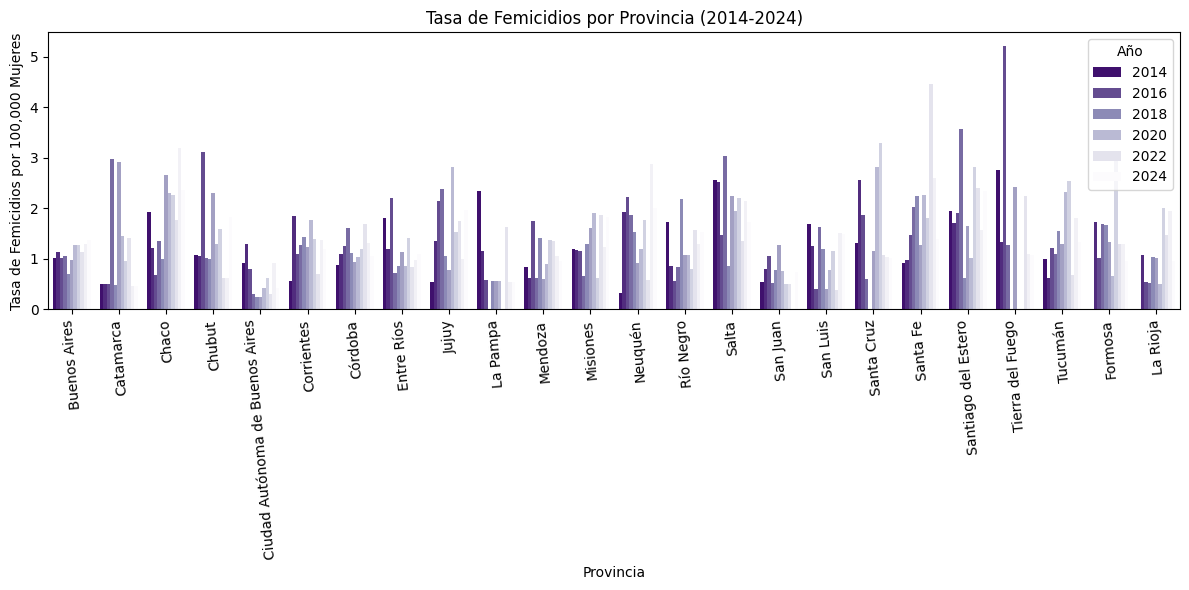

In [82]:
#provincias con mas tasa de femicidios
plt.figure(figsize=(12, 6)) 
sns.barplot(data=df_tasa, x='Provincia', y='Tasa_Femicidios', hue='Año', palette='Purples_r')
plt.title('Tasa de Femicidios por Provincia (2014-2024)')
plt.xlabel('Provincia')
plt.ylabel('Tasa de Femicidios por 100,000 Mujeres')    
plt.xticks(rotation=95)
plt.legend(title='Año') 
plt.tight_layout()
plt.show()

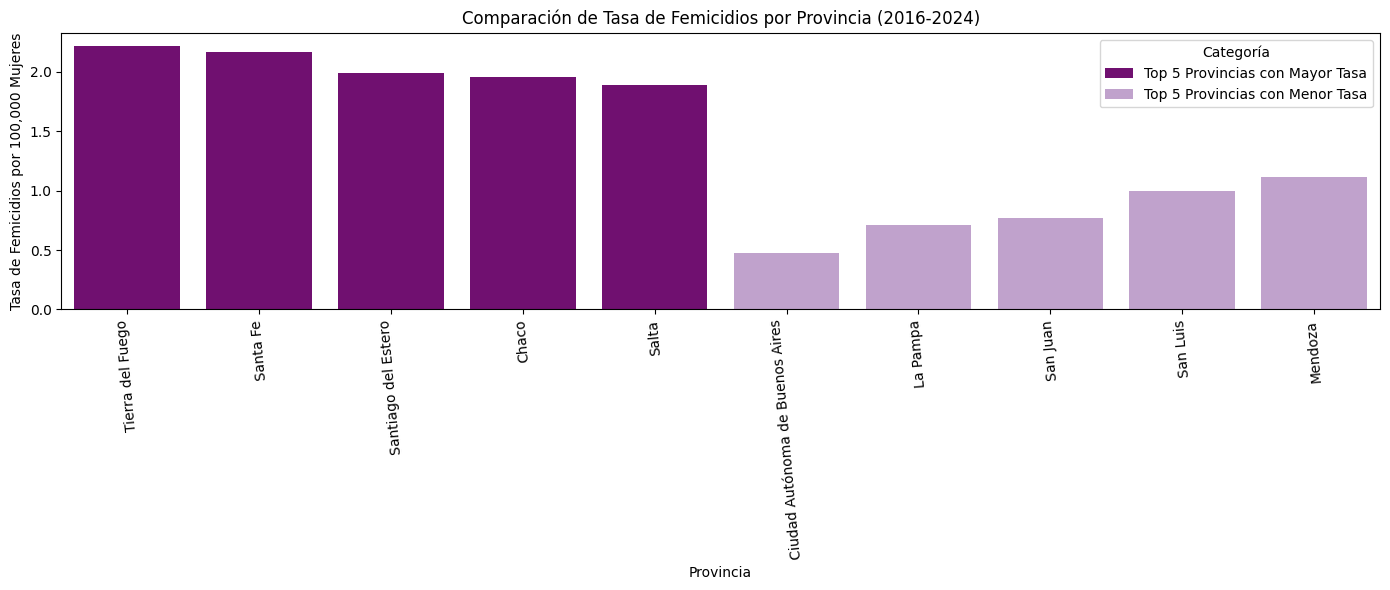

In [83]:

# Filtrar por años entre 2016 y 2024
df_tasa_filtrada = df_tasa[df_tasa['Año'].between(2016, 2024)]

# Calcular tasa promedio por provincia
tasa_media = df_tasa_filtrada.groupby('Provincia')['Tasa_Femicidios'].mean().reset_index()

# Ordenar y obtener top 5 y bottom 5
top_provincias = tasa_media.sort_values('Tasa_Femicidios', ascending=False).head(5)
bottom_provincias = tasa_media.sort_values('Tasa_Femicidios').head(5)
#graficar ambos top y bottom provincias
plt.figure(figsize=(14, 6))
sns.barplot(data=top_provincias, x='Provincia', y='Tasa_Femicidios', color='purple', label='Top 5 Provincias con Mayor Tasa')
sns.barplot(data=bottom_provincias, x='Provincia', y='Tasa_Femicidios', color='#c39bd3', label='Top 5 Provincias con Menor Tasa')  # light purple hex
plt.title('Comparación de Tasa de Femicidios por Provincia (2016-2024)')
plt.xlabel('Provincia')
plt.ylabel('Tasa de Femicidios por 100,000 Mujeres')
plt.xticks(rotation=95)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

In [84]:
tasa_media

,Provincia,Tasa_Femicidios
0,Buenos Aires,1.122698
1,Catamarca,1.292826
2,Chaco,1.952933
3,Chubut,1.490126
4,Ciudad Autónoma de Buenos Aires,0.477027
5,Corrientes,1.273360
6,Córdoba,1.244293
7,Entre Ríos,1.122655
8,Formosa,1.427024
9,Jujuy,1.713437


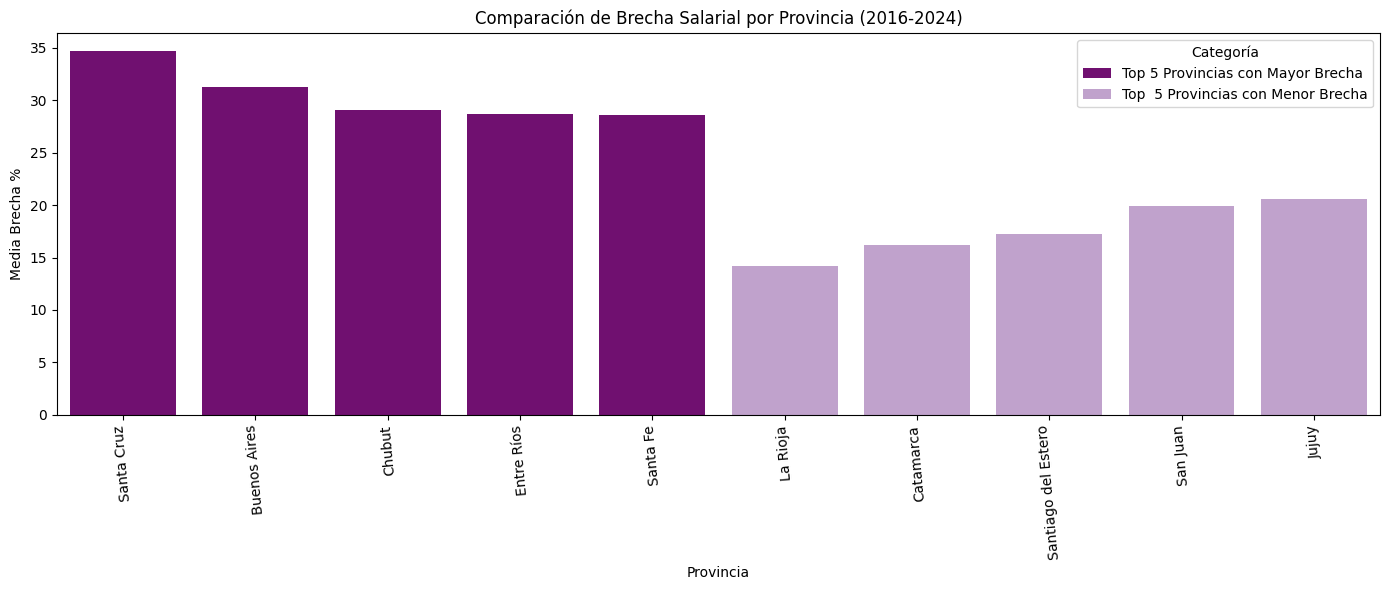

In [85]:

top_brecha = df_ingresos_total.groupby('Provincia')['Media Brecha %'].mean().reset_index()
top_brecha = top_brecha.sort_values(by='Media Brecha %', ascending=False).head(5)
bottom_brecha = df_ingresos_total.groupby('Provincia')['Media Brecha %'].mean().reset_index()
bottom_brecha = bottom_brecha.sort_values(by='Media Brecha %', ascending=True).head(5)

# Graficar ambos top y bottom provincias
plt.figure(figsize=(14, 6))     
sns.barplot(data=top_brecha, x='Provincia', y='Media Brecha %', color='purple', label='Top 5 Provincias con Mayor Brecha')
sns.barplot(data=bottom_brecha, x='Provincia', y='Media Brecha %', color='#c39bd3', label='Top  5 Provincias con Menor Brecha')  # light purple hex
plt.title('Comparación de Brecha Salarial por Provincia (2016-2024)')   
plt.xlabel('Provincia')
plt.ylabel('Media Brecha %')                            
plt.xticks(rotation=95) 
plt.legend(title='Categoría')   
plt.tight_layout()
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



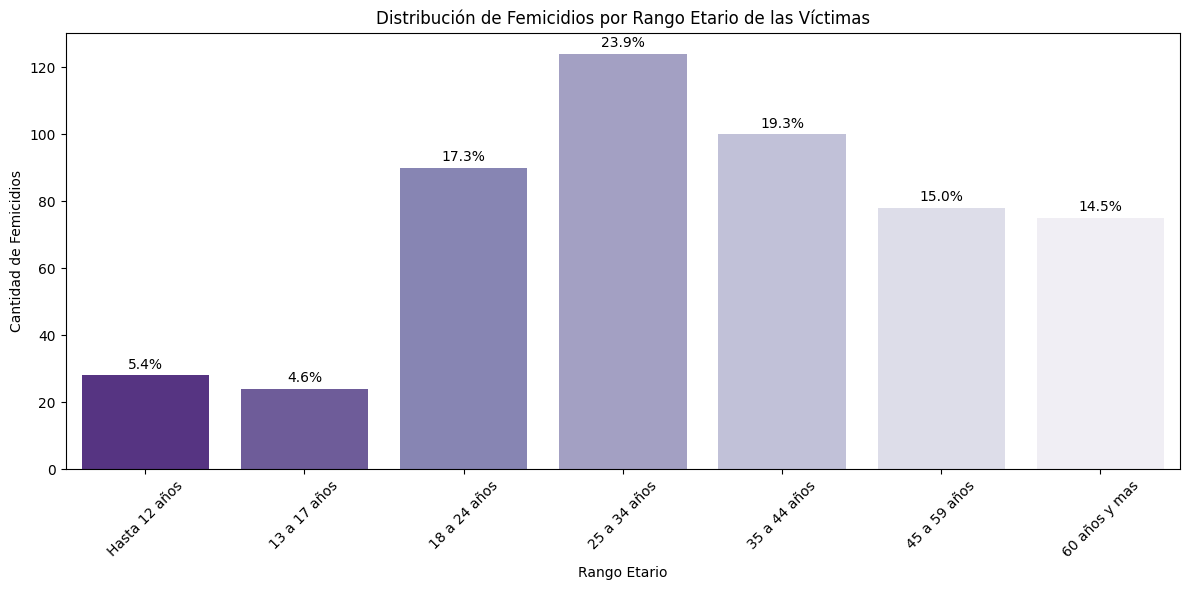

Index(['baleada', 'otros', 'golpes', 'ahorcada', 'quemada', 'no determinado',
       'incendiada la casa', 'descuartizada', 'desaparecida', 'violada',
       'hachazos', 'no informado', 'arrojada', 'ahogada', 'suicidio',
       'drogada', 'envenenada', 'martillazos', 'asfixiada', 'enterrada',
       'choque intencional', 'desangrada', 'piedrazos', 'intoxicada',
       'estrangulada', 'arrollada', 'deshidratada', 'parto forzado',
       'sobredosis'],
      dtype='object', name='forma_limpia')

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar para excluir "Sin datos"
victimas_etario = victimas_df[victimas_df['Rango_etario'] != 'Sin datos'].copy()

# Calcular conteos y porcentajes
conteos = victimas_etario['Rango_etario'].value_counts()
total = conteos.sum()
porcentajes = (conteos / total) * 100

# Orden deseado de los rangos etarios
orden_rango = [
    'Hasta 12 años',
    '13 a 17 años',
    '18 a 24 años',
    '25 a 34 años',
    '35 a 44 años',
    '45 a 59 años',
    '60 años y mas'
]

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=victimas_etario, x='Rango_etario', palette='Purples_r', order=orden_rango)

# Añadir etiquetas con porcentaje encima de cada barra
for i, categoria in enumerate(orden_rango):
    porcentaje = porcentajes.get(categoria, 0)
    conteo = conteos.get(categoria, 0)
    ax.text(i, conteo + 1, f"{porcentaje:.1f}%", ha='center', va='bottom')

plt.title('Distribución de Femicidios por Rango Etario de las Víctimas')
plt.xlabel('Rango Etario')
plt.ylabel('Cantidad de Femicidios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

orden


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



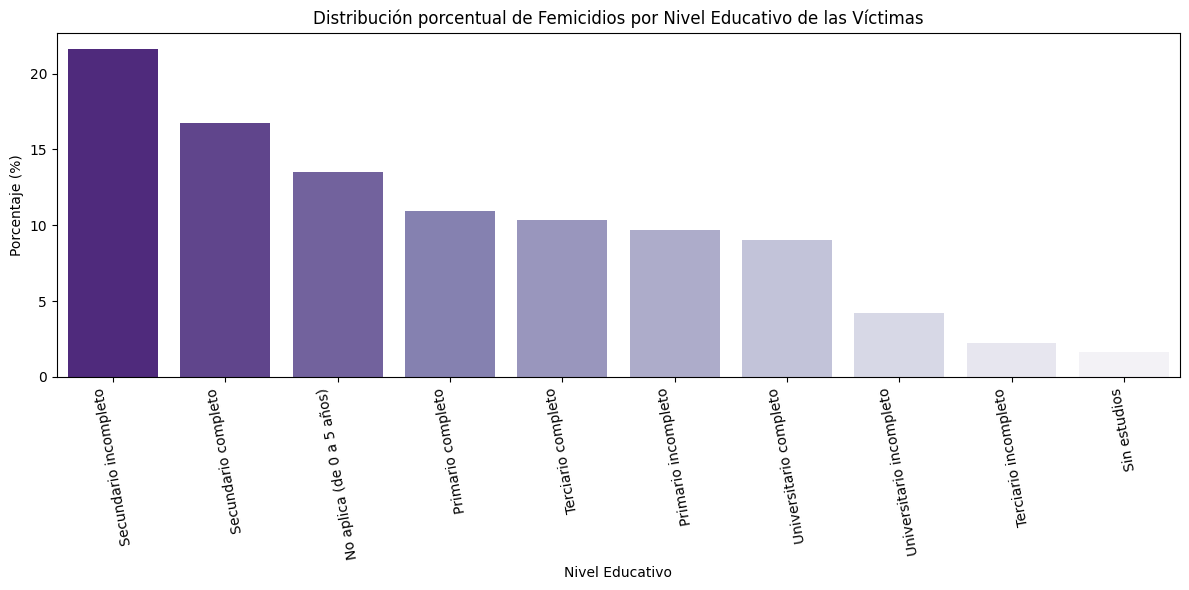

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar fuera los "Sin datos"
victimas_filtrado = victimas_df[victimas_df['Nivel_educativo'].str.lower() != 'sin datos']

# Calcular proporciones
nivel_counts = victimas_filtrado['Nivel_educativo'].value_counts(normalize=True).sort_values(ascending=False)

# Convertir a porcentaje
nivel_percent = nivel_counts * 100

# Plot
plt.figure(figsize=(12, 6)) 
sns.barplot(x=nivel_percent.index, y=nivel_percent.values, palette='Purples_r')

plt.title('Distribución porcentual de Femicidios por Nivel Educativo de las Víctimas')
plt.xlabel('Nivel Educativo')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=100)
plt.tight_layout()
plt.show()


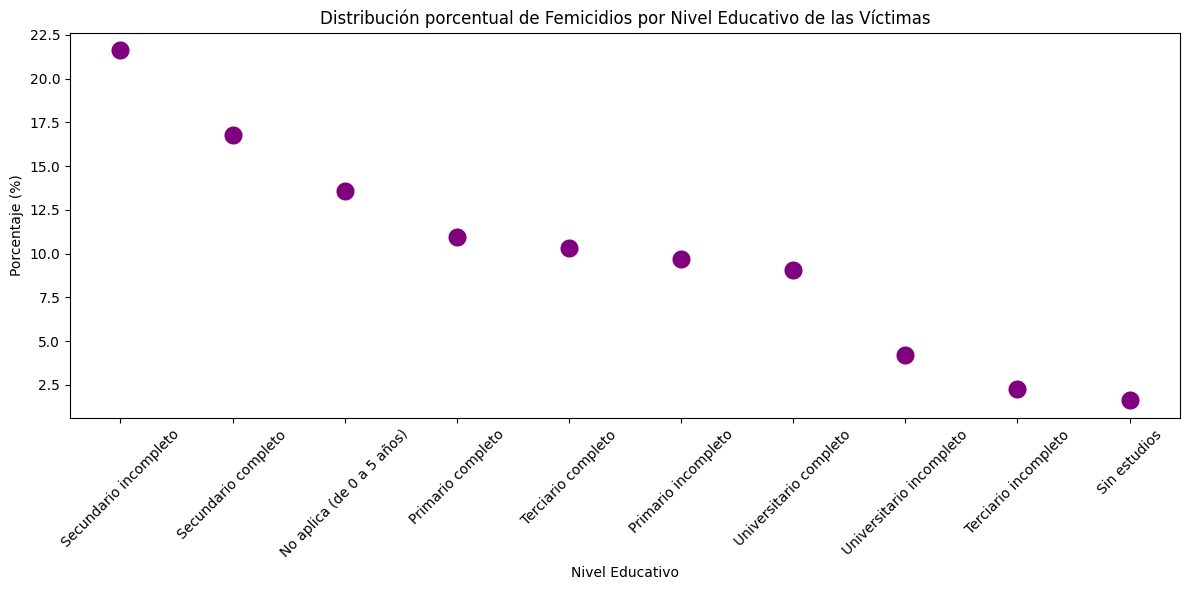

Nivel_educativo
Secundario incompleto        0.216129
Secundario completo          0.167742
No aplica (de 0 a 5 años)    0.135484
Primario completo            0.109677
Terciario completo           0.103226
Primario incompleto          0.096774
Universitario completo       0.090323
Universitario incompleto     0.041935
Terciario incompleto         0.022581
Sin estudios                 0.016129
Name: proportion, dtype: float64

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtrar fuera los "Sin datos"
victimas_filtrado = victimas_df[victimas_df['Nivel_educativo'].str.lower() != 'sin datos'].copy()

# Calcular proporciones
nivel_counts = victimas_filtrado['Nivel_educativo'].value_counts(normalize=True).sort_values(ascending=False)

# Convertir a DataFrame para usar seaborn
df_nivel = nivel_counts.reset_index()
df_nivel.columns = ['Nivel Educativo', 'Proporción']
df_nivel['Porcentaje'] = df_nivel['Proporción'] * 100

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_nivel, x='Nivel Educativo', y='Porcentaje', s=200, color='purple')

# Para que se vea mejor, rotamos etiquetas y ponemos títulos
plt.title('Distribución porcentual de Femicidios por Nivel Educativo de las Víctimas')
plt.xlabel('Nivel Educativo')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
nivel_counts


TRAEMOS DATOS DE GOOGLE TRENDS CON TRENDREQ 

In [89]:
from pytrends.request import TrendReq
import pandas as pd

pytrends = TrendReq(hl='es-AR', tz=-180)

# Lista de términos alternativos
nuevas_keywords = [
    "línea 144", "llamar 144", "violencia 144",
    "ayuda violencia de género", "número violencia de género",
    "denunciar pareja", "centro violencia de género", "denuncia violencia de género"
]

# Probar cada término individualmente
resultados_validos = {}
for kw in nuevas_keywords:
    pytrends.build_payload([kw], timeframe='2014-01-01 2025-06-25', geo='AR')
    df = pytrends.interest_over_time()
    if df[kw].sum() > 0:
        resultados_validos[kw] = df
        print(f"✅ '{kw}' tiene datos relevantes.")
    else:
        print(f"❌ '{kw}' no tiene datos suficientes.")

# Podés acceder a los DataFrames válidos en el diccionario 'resultados_validos'

✅ 'línea 144' tiene datos relevantes.
✅ 'llamar 144' tiene datos relevantes.
✅ 'violencia 144' tiene datos relevantes.
✅ 'ayuda violencia de género' tiene datos relevantes.
✅ 'número violencia de género' tiene datos relevantes.
✅ 'denunciar pareja' tiene datos relevantes.
✅ 'centro violencia de género' tiene datos relevantes.
✅ 'denuncia violencia de género' tiene datos relevantes.


In [90]:
import time
from pytrends.request import TrendReq
import pandas as pd

pytrends = TrendReq(hl='es-AR', tz=-180)

keywords_validas = [
    "línea 144", "llamar 144", "violencia 144", 'denunciar pareja','centro violencia de género',
    'ayuda violencia de género','número violencia de género'
]

df_trends = pd.DataFrame()

for kw in keywords_validas:
    pytrends.build_payload([kw], timeframe='2014-01-01 2025-06-25', geo='AR')
    df_temp = pytrends.interest_over_time()
    if 'isPartial' in df_temp.columns:
        df_temp = df_temp.drop(columns=['isPartial'])
    if df_trends.empty:
        df_trends = df_temp
    else:
        df_trends = df_trends.join(df_temp, how='outer')
    time.sleep(5)  # pausa 5 segundos para no saturar a Google

print("Datos descargados correctamente")

Datos descargados correctamente


CALCULAMOS EL INTERES TOTAL DE LAS BUSQUEDAS POR AÑO

In [91]:
df_trends = pd.concat([resultados_validos[kw][kw] for kw in resultados_validos], axis=1)

# Luego la suma o promedio
df_trends['interes_total'] = df_trends.sum(axis=1)

# Añadir año para agrupar anual (opcional)
df_trends['Año'] = df_trends.index.year

df_trends_anual = df_trends.groupby('Año')['interes_total'].mean().reset_index()

df_trends_anual

,Año,interes_total
0,2014,6.833333
1,2015,17.500000
2,2016,17.083333
3,2017,51.416667
4,2018,79.583333
5,2019,52.333333
6,2020,151.000000
7,2021,146.000000
8,2022,237.000000
9,2023,173.083333


In [ ]:
grupos_keywords = {
    'interes_denunciar': [
        "denunciar violencia", "denunciar pareja", "hacer denuncia violencia"
    ],
    'interes_144': [
        "línea 144", "llamar 144", "violencia 144"
    ],
    'interes_ayuda': [
        "ayuda violencia de género", "número violencia de género", "centro violencia de género"
    ]
}
import pandas as pd


# Primero concatenamos todas las columnas de keywords que sí tienen datos
df_trends = pd.concat([resultados_validos[kw][kw] for kw in resultados_validos], axis=1)

# Crear nuevo DataFrame para las categorías agrupadas
df_trends_agrupado = pd.DataFrame(index=df_trends.index)

for grupo, keywords in grupos_keywords.items():
    # Tomar solo las keywords que estén en df_trends para evitar errores
    kws_presentes = [kw for kw in keywords if kw in df_trends.columns]
    if kws_presentes:
        # Sumar o promediar los intereses de búsqueda de esas keywords
        df_trends_agrupado[grupo] = df_trends[kws_presentes].sum(axis=1)
    else:
        df_trends_agrupado[grupo] = 0  # O NaN si preferís

# Ahora, por ejemplo, calcular interés total
df_trends_agrupado['interes_total'] = df_trends_agrupado.sum(axis=1)

# Para analizar por año
df_trends_agrupado['Año'] = df_trends_agrupado.index.year
df_anual = df_trends_agrupado.groupby('Año').mean().reset_index()

print(df_trends_anual)
df_trends_agrupado

     Año  interes_total
0   2014       6.833333
1   2015      17.500000
2   2016      17.083333
3   2017      51.416667
4   2018      79.583333
5   2019      52.333333
6   2020     151.000000
7   2021     146.000000
8   2022     237.000000
9   2023     173.083333
10  2024     101.250000
11  2025      76.666667


,interes_denunciar,interes_144,interes_ayuda,interes_total,Año
date,,,,,
2014-01-01,0,0,0,0,2014
2014-02-01,0,0,0,0,2014
2014-03-01,0,0,0,0,2014
2014-04-01,0,0,0,0,2014
2014-05-01,0,0,0,0,2014
...,...,...,...,...,...
2025-02-01,0,0,0,0,2025
2025-03-01,73,0,59,132,2025
2025-04-01,0,0,0,0,2025


In [93]:
df_trends_anual

,Año,interes_total
0,2014,6.833333
1,2015,17.500000
2,2016,17.083333
3,2017,51.416667
4,2018,79.583333
5,2019,52.333333
6,2020,151.000000
7,2021,146.000000
8,2022,237.000000
9,2023,173.083333


UNIMOS LOS DATOS PARA COMPARAR LA TASA DE FEMICIDIOS CON EL INTERES DE BÚSQUEDA

In [94]:
df_tasa_anual = df_tasa.groupby('Año').agg({'Tasa_Femicidios': 'mean'}).reset_index()
df_trends_tasa = pd.merge(
    df_tasa_anual,
    df_trends_anual[['Año', 'interes_total']],
    on='Año',
    how='inner'  # o 'left' según tus datos
)
df_trends_tasa


,Año,Tasa_Femicidios,interes_total
0,2014,1.292295,6.833333
1,2015,1.292820,17.500000
2,2016,1.469472,17.083333
3,2017,1.418800,51.416667
4,2018,1.130707,79.583333
5,2019,1.334489,52.333333
6,2020,1.386325,151.000000
7,2021,1.637110,146.000000
8,2022,1.378888,237.000000
9,2023,1.440777,173.083333


RELACIÓN ENTRE VISIBILIDAD, MOVILIZACIÓN E INTERES DE BÚSQUEDA

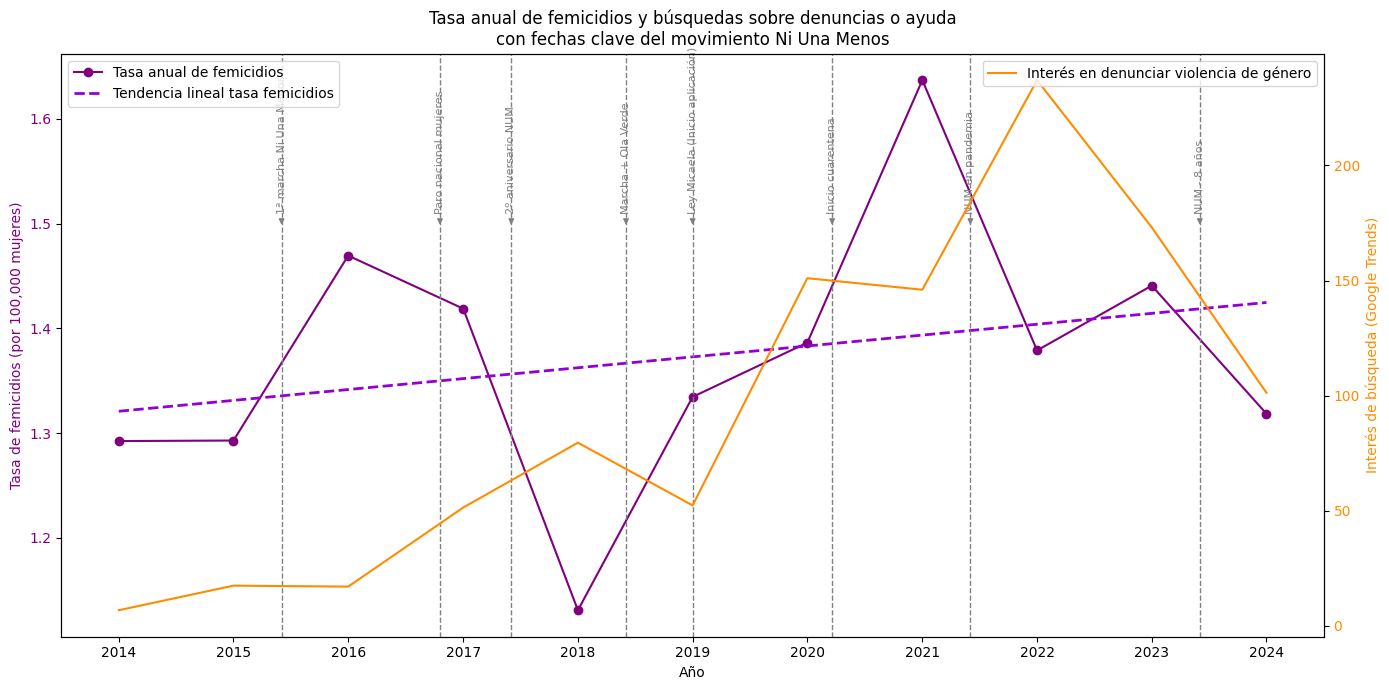

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Si 'Año' es entero, convertir a datetime para manejar fechas
if not np.issubdtype(df_trends_tasa['Año'].dtype, np.datetime64):
    df_trends_tasa['Fecha'] = pd.to_datetime(df_trends_tasa['Año'], format='%Y')
else:
    df_trends_tasa['Fecha'] = df_trends_tasa['Año']

# Convertir fechas a números para regresión lineal
x_num = df_trends_tasa['Fecha'].astype(np.int64) // 10**9
y = df_trends_tasa['Tasa_Femicidios'].fillna(0)

# Ajustar polinomio de grado 1 (regresión lineal)
coef = np.polyfit(x_num, y, 1)
poly1d_fn = np.poly1d(coef)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Graficar tasa anual y tendencia
ax1.plot(df_trends_tasa['Fecha'], df_trends_tasa['Tasa_Femicidios'], marker='o', color='purple', label='Tasa anual de femicidios')
ax1.plot(df_trends_tasa['Fecha'], poly1d_fn(x_num), color='darkviolet', linestyle='--', linewidth=2, label='Tendencia lineal tasa femicidios')

ax1.set_ylabel("Tasa de femicidios (por 100,000 mujeres)", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.set_xlabel("Año")

# Fechas clave con eventos
fechas_clave = {
    '2015-06-03': '1ª marcha Ni Una Menos',
    '2016-10-19': 'Paro nacional mujeres',
    '2017-06-03': '2º aniversario NUM',
    '2018-06-03': 'Marcha + Ola Verde',
    '2019-01-01': 'Ley Micaela (Inicio aplicación)',
    '2020-03-20': 'Inicio cuarentena',
    '2021-06-03': 'NUM en pandemia',
    '2023-06-03': 'NUM - 8 años'
}

for fecha_str, evento in fechas_clave.items():
    fecha_dt = pd.to_datetime(fecha_str)
    if fecha_dt >= df_trends_tasa['Fecha'].min() and fecha_dt <= df_trends_tasa['Fecha'].max():
        ax1.axvline(fecha_dt, color='gray', linestyle='--', linewidth=1)
        ax1.annotate(evento,
                     xy=(fecha_dt, ax1.get_ylim()[1]*0.9),
                     xytext=(0, 10),
                     textcoords='offset points',
                     rotation=90,
                     ha='center',
                     va='bottom',
                     fontsize=8,
                     color='gray',
                     arrowprops=dict(arrowstyle='-|>', color='gray'))

# Eje secundario para interés de búsqueda Google Trends
ax2 = ax1.twinx()
ax2.plot(df_trends_tasa['Fecha'], df_trends_tasa['interes_total'], color='darkorange', label='Interés en denunciar violencia de género')
ax2.set_ylabel("Interés de búsqueda (Google Trends)", color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Leyendas
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title("Tasa anual de femicidios y búsquedas sobre denuncias o ayuda\ncon fechas clave del movimiento Ni Una Menos")
plt.tight_layout()
plt.show()


UTILIZAMOS GEOPANDAS PARA TRAER EL MAPA QUE UTILIZAREMOS DE BASE.

In [96]:
import geopandas as gpd

url = "https://gist.githubusercontent.com/aguspina/570fe8c52bb9628f38618ad9b037f4e7/raw/argentina.geojson"
mapa = gpd.read_file(url)
print(mapa.columns)
print(mapa.columns)
print(mapa.head()[['geometry']])
print(mapa.head())


Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'ID_2', 'NAME_2', 'NAME_1', 'TYPE_1',
       'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1', 'geometry'],
      dtype='object')
Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'ID_2', 'NAME_2', 'NAME_1', 'TYPE_1',
       'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1', 'geometry'],
      dtype='object')
                                            geometry
0  MULTIPOLYGON (((-62.31708 -40.52319, -62.31792...
1  POLYGON ((-62.12615 -30.47898, -62.14537 -30.4...
2  POLYGON ((-66.08162 -26.21938, -66.09342 -26.2...
3  POLYGON ((-58.36434 -26.86497, -58.36386 -26.8...
4  MULTIPOLYGON (((-66.00847 -45.07986, -66.02319...
   ID_0   ISO     NAME_0  ID_1  ID_2     NAME_2        NAME_1     TYPE_1  \
0    12  AR-B  Argentina     1     1             Buenos Aires  Provincia   
1    12  AR-X  Argentina     2     2    Córdoba       Córdoba  Provincia   
2    12  AR-K  Argentina     3     3  Catamarca     Catamarca  Provincia   
3    12  AR-H  Argentina     4     4      Chaco         Chac

In [97]:
# Agrupar femicidios por provincia
df_fem_prov = femicidios_df.groupby('Provincia').size().reset_index(name='Femicidios')

# Revisar nombres de provincias para asegurarnos que coincidan con 'NAME_1'
print(df_fem_prov['Provincia'].unique())
print(mapa['NAME_1'].unique())

# Hacer merge entre el GeoDataFrame y df_fem_prov
gdf_map = mapa.merge(df_fem_prov, left_on='NAME_1', right_on='Provincia', how='left')

# Rellenar NaN en femicidios con 0 (provincias sin datos)
gdf_map['Femicidios'] = gdf_map['Femicidios'].fillna(0)

# Confirmar merge
print(gdf_map[['NAME_1', 'Femicidios']])

['Buenos Aires' 'Catamarca' 'Chaco' 'Chubut'
 'Ciudad Autónoma de Buenos Aires' 'Corrientes' 'Córdoba' 'Entre Ríos'
 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja' 'Mendoza' 'Misiones' 'Neuquén'
 'Río Negro' 'Salta' 'San Juan' 'San Luis' 'Santa Cruz' 'Santa Fe'
 'Santiago del Estero' 'Tierra del Fuego' 'Tucumán']
['Buenos Aires' 'Córdoba' 'Catamarca' 'Chaco' 'Chubut'
 'Ciudad de Buenos Aires' 'Corrientes' 'Entre Ríos' 'Formosa' 'Jujuy'
 'La Pampa' 'La Rioja' 'Mendoza' 'Misiones' 'Neuquén' 'Río Negro' 'Salta'
 'San Juan' 'San Luis' 'Santa Cruz' 'Santa Fe' 'Santiago del Estero'
 'Tierra del Fuego' 'Tucumán']
                    NAME_1  Femicidios
0             Buenos Aires      1088.0
1                  Córdoba       251.0
2                Catamarca        26.0
3                    Chaco       126.0
4                   Chubut        47.0
5   Ciudad de Buenos Aires         0.0
6               Corrientes        78.0
7               Entre Ríos        91.0
8                  Formosa        44.0
9  

In [98]:
# Diccionario para normalizar nombres de provincias entre df_fem_prov y gdf_map o df_poblacion_fem
reemplazos_provincias = {
    'Ciudad Autónoma de Buenos Aires': 'Ciudad de Buenos Aires',
    'CABA': 'Ciudad de Buenos Aires',
    'Capital Federal': 'Ciudad de Buenos Aires',
    'Cordoba': 'Córdoba',
    'Cordoba': 'Córdoba',
    'Entre Rios': 'Entre Ríos',
    'Rio Negro': 'Río Negro',
    'Neuquen': 'Neuquén',
    'Tierra Del Fuego': 'Tierra del Fuego',
    'Santiago Del Estero': 'Santiago del Estero',
    'Tucuman': 'Tucumán',
    'Otro País': None  # Si no quieres usar 'Otro País', lo puedes poner a None para eliminarlo
}

# Aplicar los reemplazos en df_fem_prov
femicidios_prov['Provincia'] = femicidios_prov['Provincia'].replace(reemplazos_provincias)

# También aplica lo mismo en df_poblacion_fem si usas este dataset para merge
df_poblacion_fem['Provincia'] = df_poblacion_fem['Provincia'].replace(reemplazos_provincias)


REALIZAMOS EL MISMO PROCESO QUE ANTES CON TRENDREQ PERO ESTA VEZ PARA VER EL INTERES TOTAL POR PROVINCIA.

In [99]:
import time
from pytrends.request import TrendReq
import pandas as pd

pytrends = TrendReq(hl='es-AR', tz=-180)

keywords_validas = [
    "línea 144", "llamar 144", "violencia 144",
    'denunciar pareja', 'centro violencia de género',
    'ayuda violencia de género', 'número violencia de género'
]

df_prov = pd.DataFrame()

for kw in keywords_validas:
    pytrends.build_payload([kw], timeframe='2014-01-01 2025-06-25', geo='AR')
    
    # Descargar interés por provincia
    df_temp = pytrends.interest_by_region(resolution='province', inc_low_vol=True)
    
    # Reiniciar índice para unir luego
    df_temp = df_temp.reset_index()
    
    # Renombrar columna de interés para esta keyword
    df_temp = df_temp.rename(columns={kw: kw + '_interes'})
    
    if df_prov.empty:
        df_prov = df_temp
    else:
        # Unir resultados por provincia
        df_prov = pd.merge(df_prov, df_temp, on='geoName', how='outer')
    
    time.sleep(5)  # Pausa para no saturar el servidor

# Reemplazar NaN por 0
df_prov = df_prov.fillna(0)

print(df_prov.head())


                           geoName  línea 144_interes  llamar 144_interes  \
0                     Buenos Aires                 68                  73   
1                        Catamarca                  0                   0   
2                            Chaco                  0                   0   
3                           Chubut                  0                   0   
4  Ciudad Autónoma de Buenos Aires                100                  50   

   violencia 144_interes  denunciar pareja_interes  \
0                     80                        44   
1                    100                         0   
2                     71                         0   
3                     47                         0   
4                     85                        40   

   centro violencia de género_interes  ayuda violencia de género_interes  \
0                                   9                                 39   
1                                   0                       

In [108]:
# Provincias en el DataFrame de marchas
provincias_marchas = set(marchas_df['Provincia'].unique())

# Provincias en el DataFrame de interés (Google Trends)
provincias_trends = set(df_prov['geoName'].unique())

# Provincias que están en marchas pero no en trends
print("Provincias en marchas_df pero no en df_prov:")
print(provincias_marchas - provincias_trends)

# Provincias que están en trends pero no en marchas
print("\nProvincias en df_prov pero no en marchas_df:")
print(provincias_trends - provincias_marchas)



Provincias en marchas_df pero no en df_prov:
{'Misiones'}

Provincias en df_prov pero no en marchas_df:
{'Misiónes'}


In [112]:
df_prov['geoName'] = df_prov['geoName'].replace({'Misiónes': 'Misiones'})


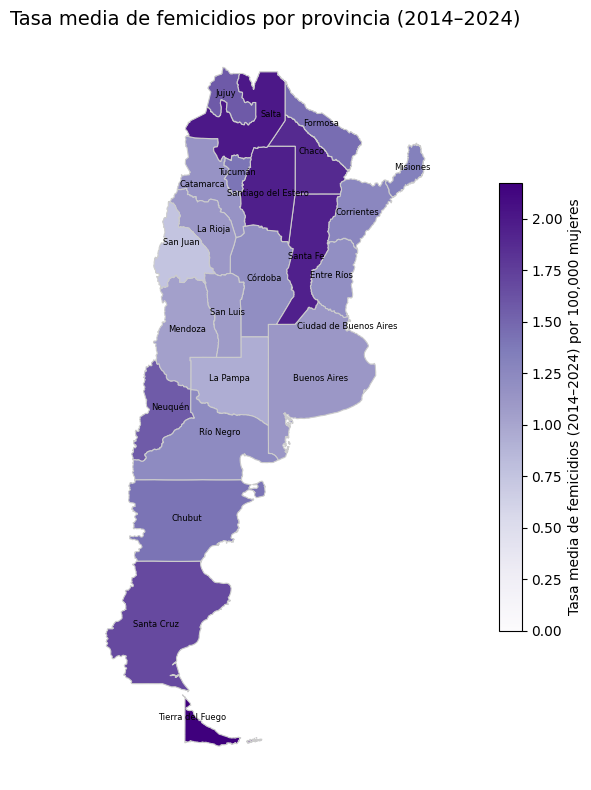

In [101]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- 1. Cargar GeoDataFrame (mapa de provincias) ---
url = "https://gist.githubusercontent.com/aguspina/570fe8c52bb9628f38618ad9b037f4e7/raw/argentina.geojson"
mapa_provincias = gpd.read_file(url)

# --- 2. Filtrar df_tasa para el rango de años deseado ---
df_tasa_filtrada = df_tasa[df_tasa['Año'].between(2014, 2024)].copy()

# --- 3. Calcular tasa media por provincia ---
tasa_media_por_provincia = df_tasa_filtrada.groupby('Provincia')['Tasa_Femicidios'].mean().reset_index()

# --- 4. Normalizar nombres para hacer merge con el mapa ---
reemplazos = {
    'Capital Federal': 'Ciudad de Buenos Aires',
    'CABA': 'Ciudad de Buenos Aires',
    'Cordoba': 'Córdoba',
    'Entre Rios': 'Entre Ríos',
    'Neuquen': 'Neuquén',
    'Rio Negro': 'Río Negro',
    'Tucuman': 'Tucumán',
}
tasa_media_por_provincia['Provincia'] = tasa_media_por_provincia['Provincia'].replace(reemplazos)

# --- 5. Hacer merge entre mapa y tasas medias ---
gdf_media_tasa = mapa_provincias.merge(
    tasa_media_por_provincia,
    left_on='NAME_1',
    right_on='Provincia',
    how='left'
)

# Reemplazar NaN por 0 para tasa (provincias sin datos)
gdf_media_tasa['Tasa_Femicidios'] = gdf_media_tasa['Tasa_Femicidios'].fillna(0)

# --- 6. Graficar mapa ---
fig, ax = plt.subplots(figsize=(12, 8))
gdf_media_tasa.plot(
    column='Tasa_Femicidios',
    cmap='Purples',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "Tasa media de femicidios (2014–2024) por 100,000 mujeres", 'shrink': 0.6}
)

ax.set_title("Tasa media de femicidios por provincia (2014–2024)", fontsize=14)
ax.axis('off')

# Añadir etiquetas de provincias centradas
for idx, row in gdf_media_tasa.iterrows():
    if row['geometry'].geom_type in ['Polygon', 'MultiPolygon']:
        centroid = row['geometry'].representative_point()
        ax.annotate(
            text=row['NAME_1'],
            xy=(centroid.x, centroid.y),
            ha='center',
            fontsize=6,
            color='black'
        )

plt.tight_layout()
plt.show()


In [ ]:
#cantidad de marchas por provincia totales (marchas_df)
# Agrupar marchas por provincia y contar la cantidad
marchas_provincia = marchas_df.groupby('Provincia').size().reset_index(name='Cantidad_marchas')

# Mostrar resultados
print(marchas_provincia)



                          Provincia  Cantidad_marchas
0                      Buenos Aires               461
1                         Catamarca                34
2                             Chaco                52
3                            Chubut                43
4   Ciudad Autónoma de Buenos Aires                79
5                        Corrientes                25
6                           Córdoba               149
7                        Entre Ríos                58
8                           Formosa                23
9                             Jujuy               133
10                         La Pampa                26
11                         La Rioja                35
12                          Mendoza                56
13                         Misiones                54
14                          Neuquén                79
15                        Río Negro                83
16                            Salta                69
17                         S

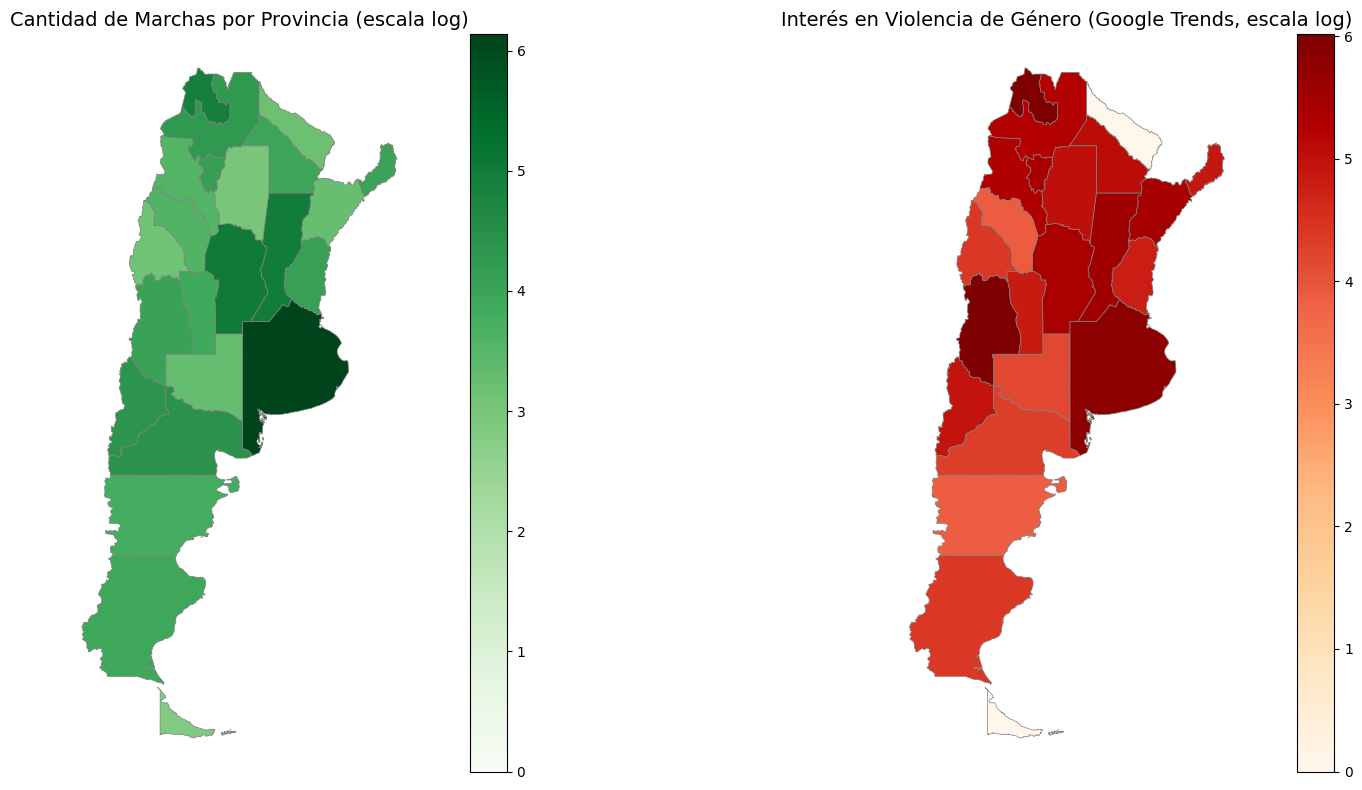

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. Cargar mapa GeoJSON ---
url = "https://gist.githubusercontent.com/aguspina/570fe8c52bb9628f38618ad9b037f4e7/raw/argentina.geojson"
mapa = gpd.read_file(url)

# --- 2. Crear columna interes_total sumando las columnas de interés ---
columnas_busqueda = [
    'línea 144_interes', 'llamar 144_interes', 'violencia 144_interes',
    'denunciar pareja_interes', 'centro violencia de género_interes',
    'ayuda violencia de género_interes', 'número violencia de género_interes'
]

df_prov['interes_total'] = df_prov[columnas_busqueda].sum(axis=1)

# --- 3. Renombrar geoName a Provincia ---
df_prov_renombrado = df_prov.rename(columns={'geoName': 'Provincia'})

# --- 4. Agrupar cantidad de marchas por provincia ---
marchas_total = marchas_df.groupby('Provincia').size().reset_index(name='Cantidad_marchas')

# --- 5. Unir interés con marchas ---
df_merge = pd.merge(
    df_prov_renombrado[['Provincia', 'interes_total']],
    marchas_total,
    on='Provincia',
    how='left'
)

# --- 6. Unir con el GeoDataFrame del mapa ---
gdf_final = mapa.merge(df_merge, left_on='NAME_1', right_on='Provincia', how='left')

# --- 7. Transformar logarítmicamente ---
gdf_final['Cantidad_marchas'] = gdf_final['Cantidad_marchas'].fillna(0)
gdf_final['interes_total'] = gdf_final['interes_total'].fillna(0)
gdf_final['Cantidad_marchas_log'] = np.log1p(gdf_final['Cantidad_marchas'])
gdf_final['interes_total_log'] = np.log1p(gdf_final['interes_total'])

# --- 8. Graficar el mapa ---
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Mapa de marchas
gdf_final.plot(
    column='Cantidad_marchas_log',
    cmap='Greens',
    linewidth=0.5,
    edgecolor='0.5',
    legend=True,
    ax=axs[0]
)
axs[0].set_title('Cantidad de Marchas por Provincia (escala log)', fontsize=14)
axs[0].axis('off')

# Mapa de interés
gdf_final.plot(
    column='interes_total_log',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='0.5',
    legend=True,
    ax=axs[1]
)
axs[1].set_title('Interés en Violencia de Género (Google Trends, escala log)', fontsize=14)
axs[1].axis('off')

plt.tight_layout()
plt.show()



In [ ]:

# 'Provincia', 'Año', 'Brecha Salarial %'

# Calculamos la media por provincia (promedio desde 2016 a 2024)
brecha_media_provincia = df_ingresos_total.groupby('Provincia')['Media Brecha %'].mean().reset_index()

# Renombramos para claridad

# Lista oficial de provincias argentinas (puedes ampliar si quieres)
provincias_oficiales = [
    'Buenos Aires', 'Catamarca', 'Chaco', 'Chubut', 'Ciudad Autónoma de Buenos Aires',
    'Corrientes', 'Córdoba', 'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja',
    'Mendoza', 'Misiones', 'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis',
    'Santa Cruz', 'Santa Fe', 'Santiago del Estero', 'Tierra del Fuego', 'Tucumán'
]

#solo provincias válidas:
brecha_media_provincia_limpio = brecha_media_provincia[
    brecha_media_provincia['Provincia'].isin(provincias_oficiales)
].copy()

# También limpia tasa_media por si hay algún dato raro
tasa_media_limpio = tasa_media[
    tasa_media['Provincia'].isin(provincias_oficiales)
].copy()

# Unimos por 'Provincia'
df_brecha_tasa = pd.merge(
    tasa_media_limpio,
    brecha_media_provincia_limpio,
    on='Provincia',
    how='inner'
)

# Renombrar columnas para que quede claro:
df_brecha_tasa.rename(columns={
    'Tasa_Femicidios': 'Tasa Femicidios',
    'Media Brecha %': 'Media Brecha %'
}, inplace=True)

print(df_brecha_tasa.head())


                         Provincia  Tasa Femicidios  Media Brecha %
0                     Buenos Aires         1.122698       31.266667
1                        Catamarca         1.292826       16.211111
2                            Chaco         1.952933       22.087500
3                           Chubut         1.490126       29.066667
4  Ciudad Autónoma de Buenos Aires         0.477027       25.144444


In [ ]:
brecha_media_provincia_limpio

,Provincia,Media Brecha %
0,Buenos Aires,31.266667
1,Catamarca,16.211111
2,Chaco,22.087500
3,Chubut,29.066667
4,Ciudad Autónoma de Buenos Aires,25.144444
5,Corrientes,27.877778
6,Córdoba,24.166667
7,Entre Ríos,28.744444
8,Formosa,22.633333
10,Jujuy,20.555556


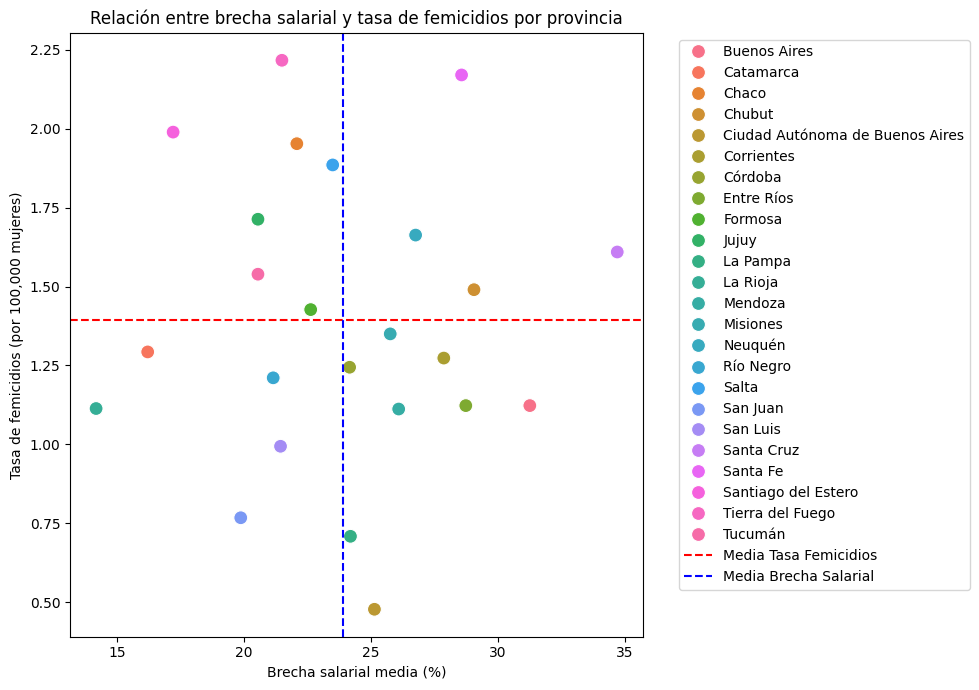

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
media_brecha = df_brecha_tasa['Media Brecha %'].mean()
media_tasa = df_brecha_tasa['Tasa Femicidios'].mean()

sns.scatterplot(data=df_brecha_tasa, x='Media Brecha %', y='Tasa Femicidios', hue='Provincia', s=100)

plt.axhline(media_tasa, color='red', linestyle='--', label='Media Tasa Femicidios')
plt.axvline(media_brecha, color='blue', linestyle='--', label='Media Brecha Salarial')

plt.title('Relación entre brecha salarial y tasa de femicidios por provincia')
plt.xlabel('Brecha salarial media (%)')
plt.ylabel('Tasa de femicidios (por 100,000 mujeres)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


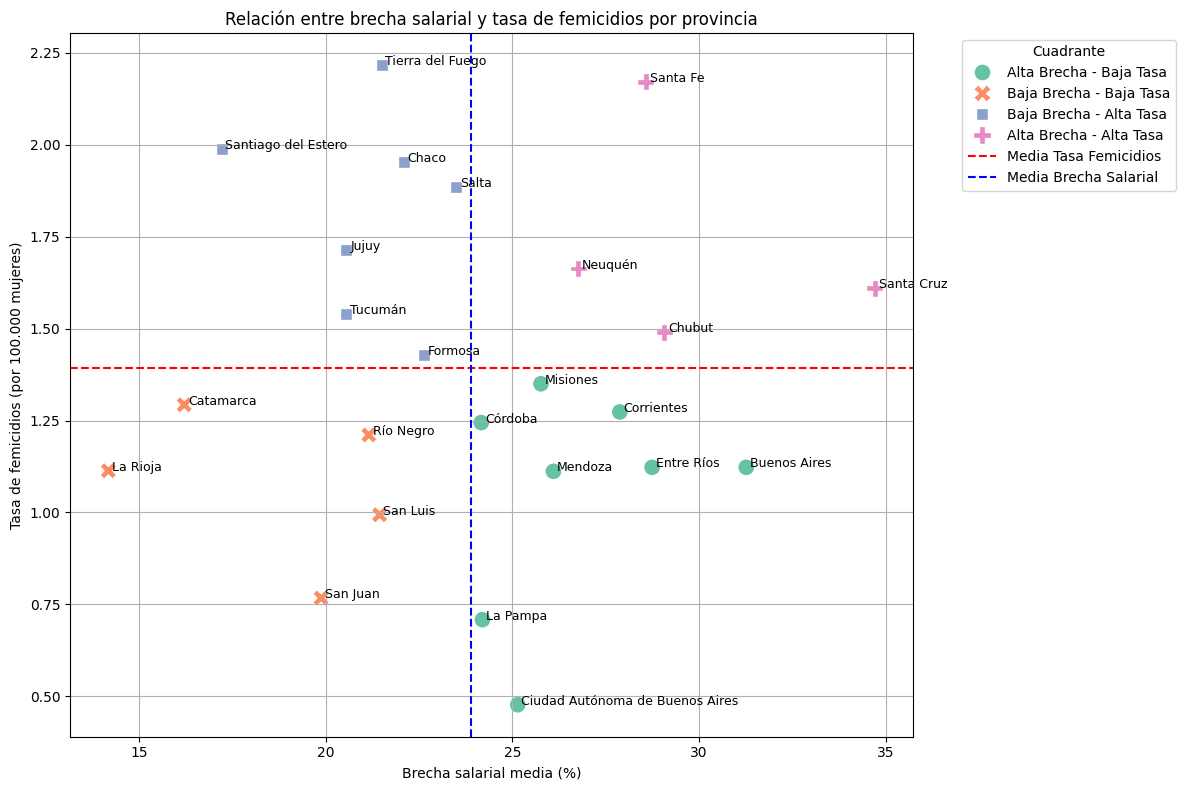

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular medias
media_brecha = df_brecha_tasa['Media Brecha %'].mean()
media_tasa = df_brecha_tasa['Tasa Femicidios'].mean()

# Clasificar cada provincia en un cuadrante
def clasificar_cuadrante(row):
    if row['Media Brecha %'] >= media_brecha and row['Tasa Femicidios'] >= media_tasa:
        return 'Alta Brecha - Alta Tasa'
    elif row['Media Brecha %'] < media_brecha and row['Tasa Femicidios'] >= media_tasa:
        return 'Baja Brecha - Alta Tasa'
    elif row['Media Brecha %'] < media_brecha and row['Tasa Femicidios'] < media_tasa:
        return 'Baja Brecha - Baja Tasa'
    else:
        return 'Alta Brecha - Baja Tasa'

df_brecha_tasa['Cuadrante'] = df_brecha_tasa.apply(clasificar_cuadrante, axis=1)

# Gráfico
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_brecha_tasa,
    x='Media Brecha %',
    y='Tasa Femicidios',
    hue='Cuadrante',
    style='Cuadrante',
    s=150,
    palette='Set2'
)

# Líneas de corte
plt.axhline(media_tasa, color='red', linestyle='--', label='Media Tasa Femicidios')
plt.axvline(media_brecha, color='blue', linestyle='--', label='Media Brecha Salarial')

# Anotar cada punto con el nombre de la provincia
for _, row in df_brecha_tasa.iterrows():
    plt.text(row['Media Brecha %'] + 0.1, row['Tasa Femicidios'], row['Provincia'], fontsize=9)

# Estética
plt.title('Relación entre brecha salarial y tasa de femicidios por provincia')
plt.xlabel('Brecha salarial media (%)')
plt.ylabel('Tasa de femicidios (por 100.000 mujeres)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cuadrante')
plt.grid(True)
plt.tight_layout()
plt.show()
